In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-cancer-wisconsin-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F180%2F408%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240610%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240610T025651Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9af5d869b4df7c0704c1ddab9b035648445729de0dc8f40b4296ea71f969fc7759741542f8960db9f83237b95ec59563fca47d7c12cf7833740babcbdb3bc7fcf1efe848fa1e8b70b47932b0ccd24d3ba962f1ea32c60295f402851482dab0e7af590b892c6b86614e2409ede2f75c263ad2ba8b6104e414d36fcfcc8a77b3fd647f8ca8912255e1dba952b37745ba2abde28dd997b758699e01d44438111de23fe18adc886e875865bf9100179aa9e8580b59ef01a96de3698a059b559842a76a1d12d90d40c579a6c0d14c693e221861c08b4fc8a6841724f3322c0c0e77e871bb14d55a3bede1ae6ddfb1d423b8618018c51279b50062f652a7eecef28bce'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 49796 bytes downloaded
Downloaded and uncompressed: breast-cancer-wisconsin-data
Data source import complete.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
%matplotlib inline
sns.set()

## split data

from sklearn.model_selection import train_test_split

## preprocessing

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## models

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


## accuracy to model

from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error,mean_absolute_error

## tuning for data

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## ANN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [4]:
df=pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
df

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0    ...          17.33           184.60      2019.0           0.16220   
1    ...          23.41           158.80      1956.0           0.12380   
2    ...          25.53           152.50      1709.0           0.14440   
3    ...          26.50            98.87       567.7           0.20980   
4    ...          16.67           152.20      1575.0           0.13740   
..   ...            ...              ...         ...               ...   
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0              0.66560           0.7119                0.2654          0.4601   
1              0.18660           0.2416                0.1860          0.2750   
2              0.42450           0.4504                0.2430          0.3613   
3              0.86630           0.6869                0.2575          0.6638   
4              0.20500           0.4000                0.1625          0.2364   
..                 ...              ...                   ...             ...   
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
0                    0.11890          NaN  
1                    0.08902          NaN  
2                    0.08758          NaN  
3                    0.17300          NaN  
4      

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [7]:
df.head(12).style.background_gradient(cmap="rainbow")

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3618: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/style.py:3619: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


In [8]:
df.tail(22)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
547  922840         B       10.260         16.58           65.85      320.8   
548  923169         B        9.683         19.34           61.05      285.7   
549  923465         B       10.820         24.21           68.89      361.6   
550  923748         B       10.860         21.48           68.51      360.5   
551  923780         B       11.130         22.44           71.49      378.4   
552  924084         B       12.770         29.43           81.35      507.9   
553  924342         B        9.333         21.94           59.01      264.0   
554  924632         B       12.880         28.92           82.50      514.3   
555  924934         B       10.290         27.61           65.67      321.4   
556  924964         B       10.160         19.59           64.73      311.7   
557  925236         B        9.423         27.88           59.26      271.3   
558  925277         B       14.590         22.68           96.39      657.1   
559  925291         B       11.510         23.93           74.52      403.5   
560  925292         B       14.050         27.15           91.38      600.4   
561  925311         B       11.200         29.37           70.67      386.0   
562  925622         M       15.220         30.62          103.40      716.9   
563  926125         M       20.920         25.09          143.00     1347.0   
564  926424         M       21.560         22.39          142.00     1479.0   
565  926682         M       20.130         28.25          131.20     1261.0   
566  926954         M       16.600         28.08          108.30      858.1   
567  927241         M       20.600         29.33          140.10     1265.0   
568   92751         B        7.760         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
547          0.08877           0.08066        0.043580             0.024380   
548          0.08491           0.05030        0.023370             0.009615   
549          0.08192           0.06602        0.015480             0.008160   
550          0.07431           0.04227        0.000000             0.000000   
551          0.09566           0.08194        0.048240             0.022570   
552          0.08276           0.04234        0.019970             0.014990   
553          0.09240           0.05605        0.039960             0.012820   
554          0.08123           0.05824        0.061950             0.023430   
555          0.09030           0.07658        0.059990             0.027380   
556          0.10030           0.07504        0.005025             0.011160   
557          0.08123           0.04971        0.000000             0.000000   
558          0.08473           0.13300        0.102900             0.037360   
559          0.09261           0.10210        0.111200             0.041050   
560          0.09929           0.11260        0.044620             0.043040   
561          0.07449           0.03558        0.000000             0.000000   
562          0.10480           0.20870        0.255000             0.094290   
563          0.10990           0.22360        0.317400             0.147400   
564          0.11100           0.11590        0.243900             0.138900   
565          0.09780           0.10340        0.144000             0.097910   
566          0.08455           0.10230        0.092510             0.053020   
567          0.11780           0.27700        0.351400             0.152000   
568          0.05263           0.04362        0.000000             0.000000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
547  ...          22.04            71.08       357.4           0.14610   
548  ...          25.59            69.10       364.2           0.11990   
549  ...          31.45            83.90       505.6           0.12040   
550  ...          24.77            74.08       412.3           0.10010   
551

In [9]:
df.describe().T

count          mean           std          min  \
id                       569.0  3.037183e+07  1.250206e+08  8670.000000   
radius_mean              569.0  1.412729e+01  3.524049e+00     6.981000   
texture_mean             569.0  1.928965e+01  4.301036e+00     9.710000   
perimeter_mean           569.0  9.196903e+01  2.429898e+01    43.790000   
area_mean                569.0  6.548891e+02  3.519141e+02   143.500000   
smoothness_mean          569.0  9.636028e-02  1.406413e-02     0.052630   
compactness_mean         569.0  1.043410e-01  5.281276e-02     0.019380   
concavity_mean           569.0  8.879932e-02  7.971981e-02     0.000000   
concave points_mean      569.0  4.891915e-02  3.880284e-02     0.000000   
symmetry_mean            569.0  1.811619e-01  2.741428e-02     0.106000   
fractal_dimension_mean   569.0  6.279761e-02  7.060363e-03     0.049960   
radius_se                569.0  4.051721e-01  2.773127e-01     0.111500   
texture_se               569.0  1.216853e+00  5.516484e-01     0.360200   
perimeter_se             569.0  2.866059e+00  2.021855e+00     0.757000   
area_se                  569.0  4.033708e+01  4.549101e+01     6.802000   
smoothness_se            569.0  7.040979e-03  3.002518e-03     0.001713   
compactness_se           569.0  2.547814e-02  1.790818e-02     0.002252   
concavity_se             569.0  3.189372e-02  3.018606e-02     0.000000   
concave points_se        569.0  1.179614e-02  6.170285e-03     0.000000   
symmetry_se              569.0  2.054230e-02  8.266372e-03     0.007882   
fractal_dimension_se     569.0  3.794904e-03  2.646071e-03     0.000895   
radius_worst             569.0  1.626919e+01  4.833242e+00     7.930000   
texture_worst            569.0  2.567722e+01  6.146258e+00    12.020000   
perimeter_worst          569.0  1.072612e+02  3.360254e+01    50.410000   
area_worst               569.0  8.805831e+02  5.693570e+02   185.200000   
smoothness_worst         569.0  1.323686e-01  2.283243e-02     0.071170   
compactness_worst        569.0  2.542650e-01  1.573365e-01     0.027290   
concavity_worst          569.0  2.721885e-01  2.086243e-01     0.000000   
concave points_worst     569.0  1.146062e-01  6.573234e-02     0.000000   
symmetry_worst           569.0  2.900756e-01  6.186747e-02     0.156500   
fractal_dimension_worst  569.0  8.394582e-02  1.806127e-02     0.055040   
Unnamed: 32                0.0           NaN           NaN          NaN   

                                   25%            50%           75%  \
id                       869218.000000  906024.000000  8.813129e+06   
radius_mean                  11.700000      13.370000  1.578000e+01   
texture_mean                 16.170000      18.840000  2.180000e+01   
perimeter_mean               75.170000      86.240000  1.041000e+02   
area_mean                   420.300000     551.100000  7.827000e+02   
smoothness_mean               0.086370       0.095870  1.053000e-01   
compactness_mean              0.064920       0.092630  1.304000e-01   
concavity_mean                0.029560       0.061540  1.307000e-01   
concave points_mean           0.020310       0.033500  7.400000e-02   
symmetry_mean                 0.161900       0.179200  1.957000e-01   
fractal_dimension_mean        0.057700       0.061540  6.612000e-02   
radius_se                     0.232400       0.324200  4.789000e-01   
texture_se                    0.833900       1.108000  1.474000e+00   
perimeter_se                  1.606000       2.287000  3.357000e+00   
area_se                      17.850000      24.530000  4.519000e+01   
smoothness_se                 0.005169       0.006380  8.146000e-03   
compactness_se                0.013080       0.020450  3.245000e-02   
concavity_se                  0.015090       0.025890  4.205000e-02   
concave points_se             0.007638       0.010930  1.471000e-02   
symmetry_se                   0.015160       0.018730  2.348000e-02   
fractal_dimension_se          0.002248       0.003187  4.5

In [10]:
df.describe(include="object")

diagnosis
count        569
unique         2
top            B
freq         357

In [11]:
df.corr(numeric_only=True)

id  radius_mean  texture_mean  perimeter_mean  \
id                       1.000000     0.074626      0.099770        0.073159   
radius_mean              0.074626     1.000000      0.323782        0.997855   
texture_mean             0.099770     0.323782      1.000000        0.329533   
perimeter_mean           0.073159     0.997855      0.329533        1.000000   
area_mean                0.096893     0.987357      0.321086        0.986507   
smoothness_mean         -0.012968     0.170581     -0.023389        0.207278   
compactness_mean         0.000096     0.506124      0.236702        0.556936   
concavity_mean           0.050080     0.676764      0.302418        0.716136   
concave points_mean      0.044158     0.822529      0.293464        0.850977   
symmetry_mean           -0.022114     0.147741      0.071401        0.183027   
fractal_dimension_mean  -0.052511    -0.311631     -0.076437       -0.261477   
radius_se                0.143048     0.679090      0.275869        0.691765   
texture_se              -0.007526    -0.097317      0.386358       -0.086761   
perimeter_se             0.137331     0.674172      0.281673        0.693135   
area_se                  0.177742     0.735864      0.259845        0.744983   
smoothness_se            0.096781    -0.222600      0.006614       -0.202694   
compactness_se           0.033961     0.206000      0.191975        0.250744   
concavity_se             0.055239     0.194204      0.143293        0.228082   
concave points_se        0.078768     0.376169      0.163851        0.407217   
symmetry_se             -0.017306    -0.104321      0.009127       -0.081629   
fractal_dimension_se     0.025725    -0.042641      0.054458       -0.005523   
radius_worst             0.082405     0.969539      0.352573        0.969476   
texture_worst            0.064720     0.297008      0.912045        0.303038   
perimeter_worst          0.079986     0.965137      0.358040        0.970387   
area_worst               0.107187     0.941082      0.343546        0.941550   
smoothness_worst         0.010338     0.119616      0.077503        0.150549   
compactness_worst       -0.002968     0.413463      0.277830        0.455774   
concavity_worst          0.023203     0.526911      0.301025        0.563879   
concave points_worst     0.035174     0.744214      0.295316        0.771241   
symmetry_worst          -0.044224     0.163953      0.105008        0.189115   
fractal_dimension_worst -0.029866     0.007066      0.119205        0.051019   
Unnamed: 32                   NaN          NaN           NaN             NaN   

                         area_mean  smoothness_mean  compactness_mean  \
id                        0.096893        -0.012968          0.000096   
radius_mean               0.987357         0.170581          0.506124   
texture_mean              0.321086        -0.023389          0.236702   
perimeter_mean            0.986507         0.207278          0.556936   
area_mean                 1.000000         0.177028          0.498502   
smoothness_mean           0.177028         1.000000          0.659123   
compactness_mean          0.498502         0.659123          1.000000   
concavity_mean            0.685983         0.521984          0.883121   
concave points_mean       0.823269         0.553695          0.831135   
symmetry_mean             0.151293         0.557775          0.602641   
fractal_dimension_mean   -0.283110         0.584792          0.565369   
radius_se                 0.732562         0.301467          0.497473   
texture_se               -0.066280         0.068406          0.046205   
perimeter_se              0.726628         0.296092          0.548905   
area_se                   0.800086         0.246552          0.455653   
smoothness_se            -0.166777         0.332375          0.135299   
compactness_se            0.212583         0.318943          0.738722   
concavity_se              0.207660         0.248396          0.570517   
con

In [12]:
df.shape

(569, 33)

In [13]:
df.sample(19)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
554    924632         B       12.880         28.92           82.50      514.3   
324  89511501         B       12.200         15.21           78.01      457.9   
99     862548         M       14.420         19.77           94.48      642.5   
545    922576         B       13.620         23.23           87.19      573.2   
317    894326         M       18.220         18.87          118.70     1027.0   
533  91930402         M       20.470         20.67          134.70     1299.0   
224   8813129         B       13.270         17.02           84.55      546.4   
158    871122         B       12.060         12.74           76.84      448.6   
263    889403         M       15.610         19.38          100.00      758.6   
368   9011971         M       21.710         17.25          140.90     1546.0   
233  88206102         M       20.510         27.81          134.40     1319.0   
416    905978         B        9.405         21.70           59.60      271.2   
540    921385         B       11.540         14.44           74.65      402.9   
296    891936         B       10.910         12.35           69.14      363.7   
245    884437         B       10.480         19.86           66.72      337.7   
230    881972         M       17.050         19.08          113.40      895.0   
355   9010258         B       12.560         19.07           81.92      485.8   
282     89122         M       19.400         18.18          127.20     1145.0   
272   8910988         M       21.750         20.99          147.30     1491.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
554          0.08123           0.05824         0.06195              0.02343   
324          0.08673           0.06545         0.01994              0.01692   
99           0.09752           0.11410         0.09388              0.05839   
545          0.09246           0.06747         0.02974              0.02443   
317          0.09746           0.11170         0.11300              0.07950   
533          0.09156           0.13130         0.15230              0.10150   
224          0.08445           0.04994         0.03554              0.02456   
158          0.09311           0.05241         0.01972              0.01963   
263          0.07840           0.05616         0.04209              0.02847   
368          0.09384           0.08562         0.11680              0.08465   
233          0.09159           0.10740         0.15540              0.08340   
416          0.10440           0.06159         0.02047              0.01257   
540          0.09984           0.11200         0.06737              0.02594   
296          0.08518           0.04721         0.01236              0.01369   
245          0.10700           0.05971         0.04831              0.03070   
230          0.11410           0.15720         0.19100              0.10900   
355          0.08760           0.10380         0.10300              0.04391   
282          0.10370           0.14420         0.16260              0.09464   
272          0.09401           0.19610         0.21950              0.10880   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
554  ...          35.74            88.84       595.7           0.12270   
324  ...          21.38            91.11       583.1           0.12560   
99   ...          30.86           109.50       826.4           0.14310   
545  ...          29.09            97.58       729.8           0.12160   
317  ...          25.00           140.90      1485.0           0.14340   
533  ...          27.15           152.00      1645.0           0.10970   
224  ...          23.60            98.84       708.8           0.12760   
158  ...          18.41            84.08       532.8           0.12750   
263  ...          31.67           115.90       988.6           0.10840   
368  ...          26.44           199.50      3143.0           0.1363

In [14]:
df["area_mean"].value_counts()

area_mean
512.2     3
1075.0    2
582.7     2
399.8     2
641.2     2
         ..
507.4     1
609.9     1
463.7     1
428.9     1
181.0     1
Name: count, Length: 539, dtype: int64

In [15]:
df.groupby("texture_mean")["area_mean"].max()

texture_mean
9.71      357.6
10.38    1001.0
10.72     409.1
10.82     403.3
10.89     640.7
          ...  
31.12    1419.0
32.47    1223.0
33.56     744.9
33.81     386.8
39.28     920.6
Name: area_mean, Length: 479, dtype: float64

In [16]:
df["id"].sort_values(ascending=False).head(21)

464    911320502
463    911320501
461    911296202
460    911296201
449    911157302
360    901034302
359    901034301
213    881094802
210    881046502
151    871001502
150    871001501
536     91979701
533     91930402
532     91903902
531     91903901
527     91813702
526     91813701
521     91762702
514     91594602
507     91544002
506     91544001
Name: id, dtype: int64

In [17]:
df["texture_mean"].min()

9.71

In [18]:
df[df["area_worst"]==df["area_mean"]].sum()

id                          9665836
diagnosis                        MM
radius_mean                    43.1
texture_mean                  43.67
perimeter_mean               284.04
area_mean                    3197.8
smoothness_mean             0.20807
compactness_mean            0.20291
concavity_mean              0.34408
concave points_mean         0.18849
symmetry_mean                0.3213
fractal_dimension_mean      0.11029
radius_se                     4.087
texture_se                    3.664
perimeter_se                 30.057
area_se                       631.6
smoothness_se              0.020333
compactness_se              0.03866
concavity_se                0.08207
concave points_se           0.03324
symmetry_se                0.055712
fractal_dimension_se        0.00623
radius_worst                   43.1
texture_worst                 43.67
perimeter_worst              284.04
area_worst                   3197.8
smoothness_worst            0.20807
compactness_worst           

In [19]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
564    False
565    False
566    False
567    False
568    False
Length: 569, dtype: bool

In [20]:
df["radius_mean"].unique

<bound method Series.unique of 0      17.99
1      20.57
2      19.69
3      11.42
4      20.29
       ...  
564    21.56
565    20.13
566    16.60
567    20.60
568     7.76
Name: radius_mean, Length: 569, dtype: float64>

In [21]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [22]:
df_corr=df.corr(numeric_only=True)[["radius_se","texture_se"]]
df_corr

radius_se  texture_se
id                        0.143048   -0.007526
radius_mean               0.679090   -0.097317
texture_mean              0.275869    0.386358
perimeter_mean            0.691765   -0.086761
area_mean                 0.732562   -0.066280
smoothness_mean           0.301467    0.068406
compactness_mean          0.497473    0.046205
concavity_mean            0.631925    0.076218
concave points_mean       0.698050    0.021480
symmetry_mean             0.303379    0.128053
fractal_dimension_mean    0.000111    0.164174
radius_se                 1.000000    0.213247
texture_se                0.213247    1.000000
perimeter_se              0.972794    0.223171
area_se                   0.951830    0.111567
smoothness_se             0.164514    0.397243
compactness_se            0.356065    0.231700
concavity_se              0.332358    0.194998
concave points_se         0.513346    0.230283
symmetry_se               0.240567    0.411621
fractal_dimension_se      0.227754    0.279723
radius_worst              0.715065   -0.111690
texture_worst             0.194799    0.409003
perimeter_worst           0.719684   -0.102242
area_worst                0.751548   -0.083195
smoothness_worst          0.141919   -0.073658
compactness_worst         0.287103   -0.092439
concavity_worst           0.380585   -0.068956
concave points_worst      0.531062   -0.119638
symmetry_worst            0.094543   -0.128215
fractal_dimension_worst   0.049559   -0.045655
Unnamed: 32                    NaN         NaN

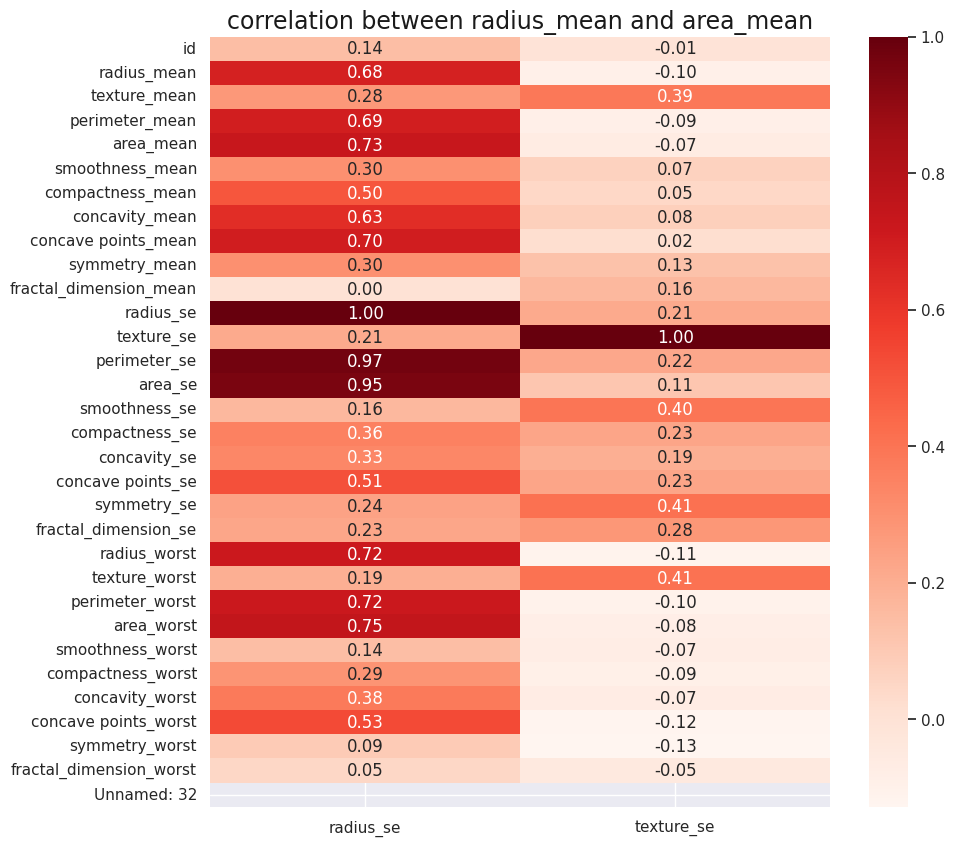

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(df_corr,annot=True,fmt=".2f",cmap="Reds")
plt.title("correlation between radius_mean and area_mean",fontsize=17,c="k")
plt.show()

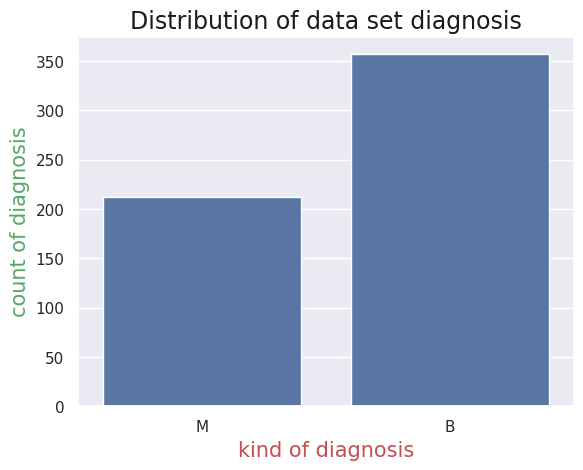

In [24]:
sns.countplot(x="diagnosis",data=df)
plt.title("Distribution of data set diagnosis",fontsize=17,c="k")
plt.xlabel("kind of diagnosis",fontsize=15,c="r")
plt.ylabel("count of diagnosis",fontsize=15,c="g")
plt.show()

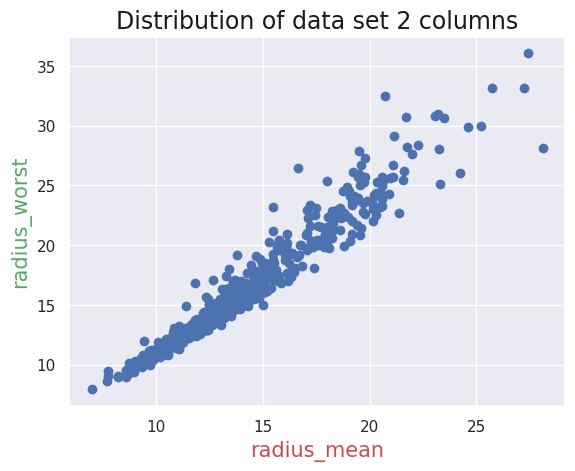

In [25]:
plt.scatter(x=df["radius_mean"],y=df["radius_worst"],c="b")
plt.title("Distribution of data set 2 columns",fontsize=17,c="k")
plt.xlabel("radius_mean",fontsize=15,c="r")
plt.ylabel("radius_worst",fontsize=15,c="g")
plt.show()

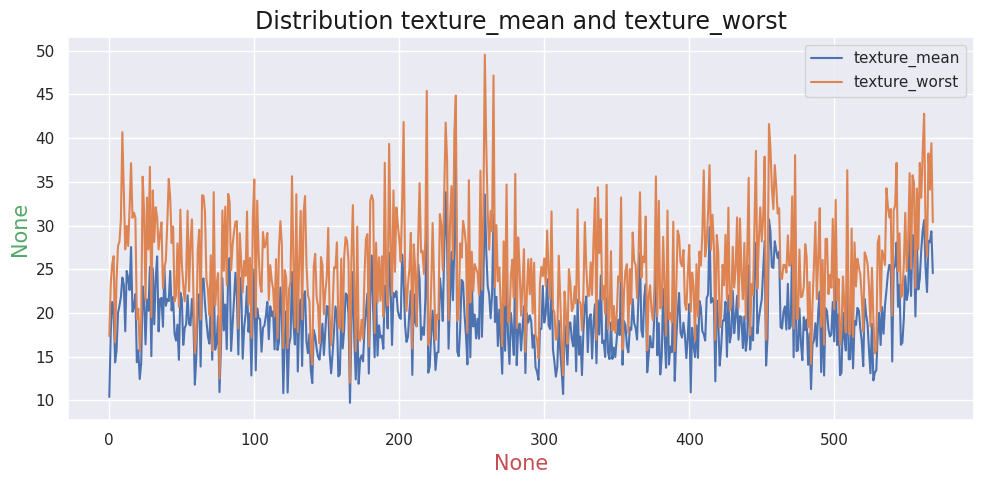

In [26]:
plt.figure(figsize=(10,5))
df["texture_mean"].plot()
df["texture_worst"].plot()
plt.title("Distribution texture_mean and texture_worst",fontsize=17,c="k")
plt.xlabel("None",fontsize=15,c="r")
plt.ylabel("None",fontsize=15,c="g")
plt.legend(["texture_mean","texture_worst"])
plt.tight_layout()
plt.show()


<ipython-input-28-c79871da75c5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["radius_mean"])


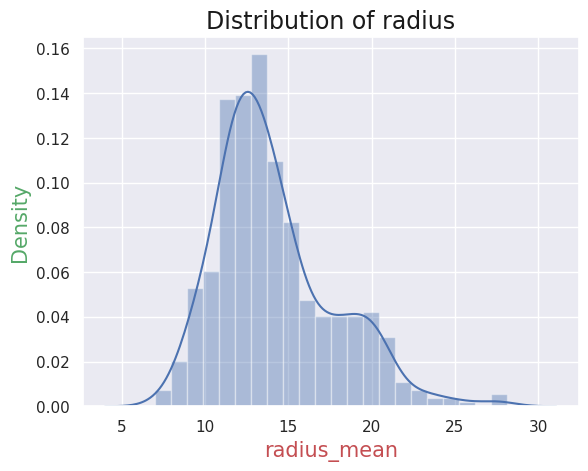

In [28]:
sns.distplot(df["radius_mean"])
plt.title("Distribution of radius",fontsize=17,c="k")
plt.xlabel("radius_mean",fontsize=15,c="r")
plt.ylabel("Density",fontsize=15,c="g")
plt.show()


<ipython-input-29-6255b419fa00>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["radius_worst"],kde=False,color="r")


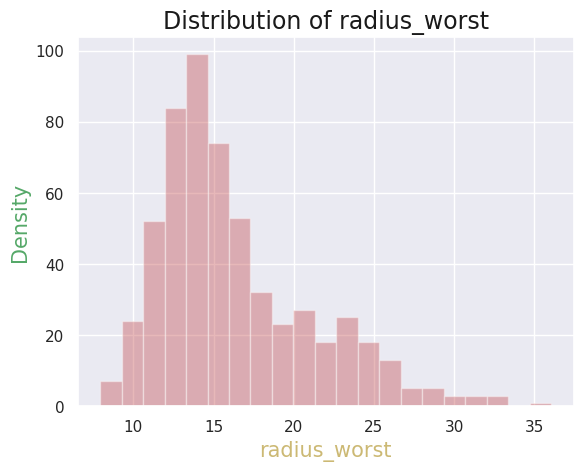

In [29]:
sns.distplot(df["radius_worst"],kde=False,color="r")
plt.title("Distribution of radius_worst",fontsize=17,c="k")
plt.xlabel("radius_worst",fontsize=15,c="y")
plt.ylabel("Density",fontsize=15,c="g")
plt.show()


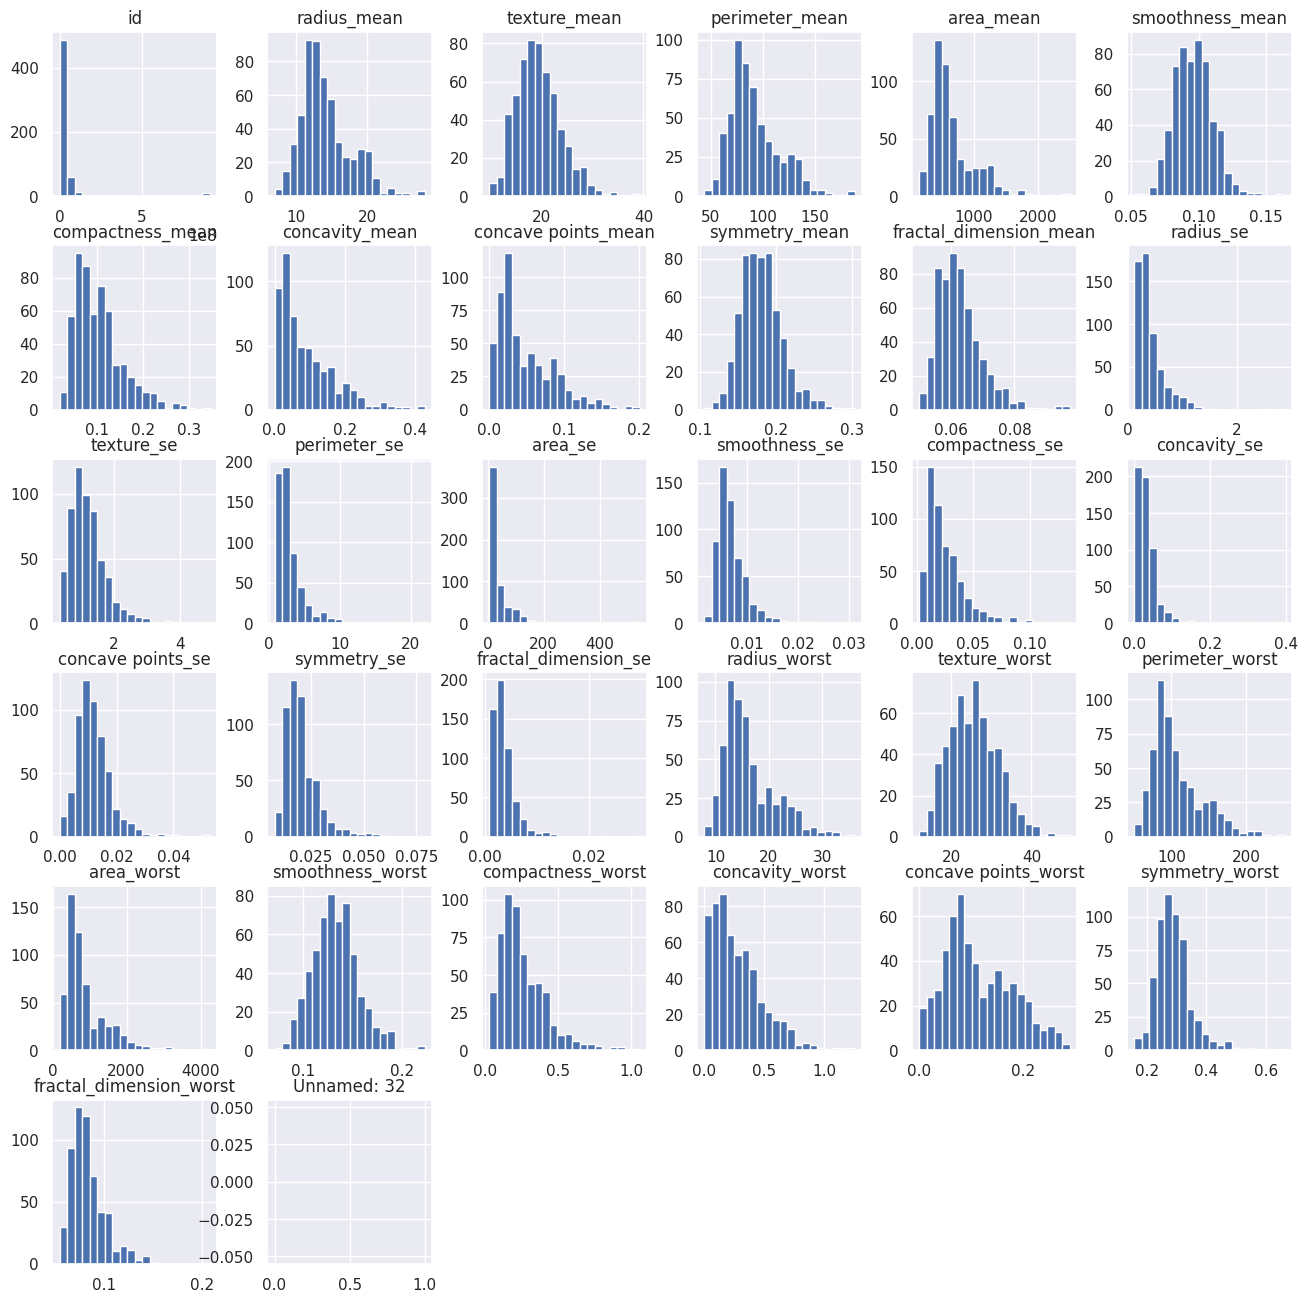

In [30]:
df.hist(bins=20,figsize=(16,16))
plt.show()

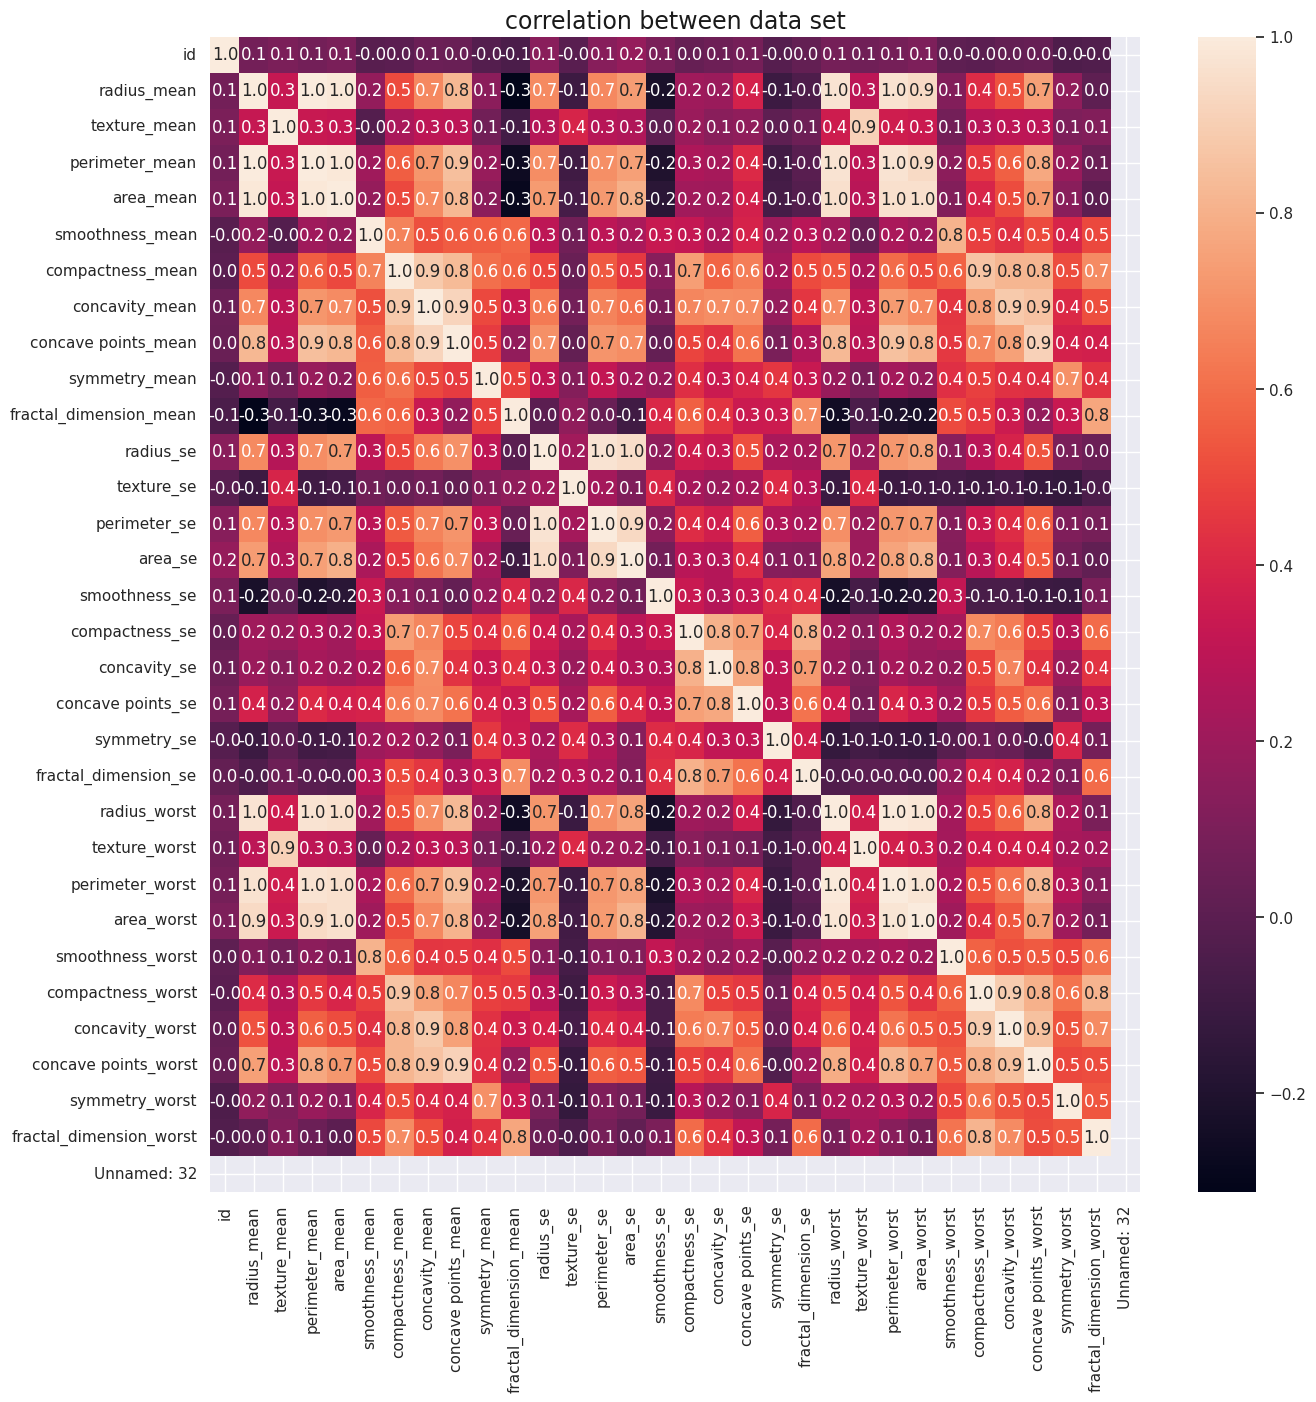

In [31]:
plt.figure(figsize=(15,15))
c=df.corr(numeric_only=True)
sns.heatmap(c,annot=True,fmt=".1f")
plt.title("correlation between data set",fontsize=17,c="k")
plt.show()

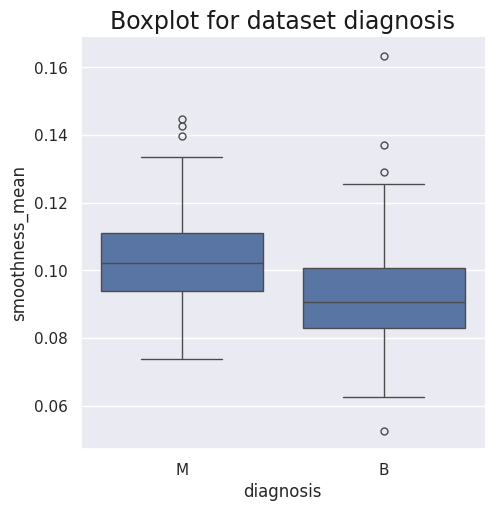

In [32]:
sns.catplot(x="diagnosis",y="smoothness_mean",data=df,kind="box")
plt.title("Boxplot for dataset diagnosis",fontsize=17,c="k")
plt.show()


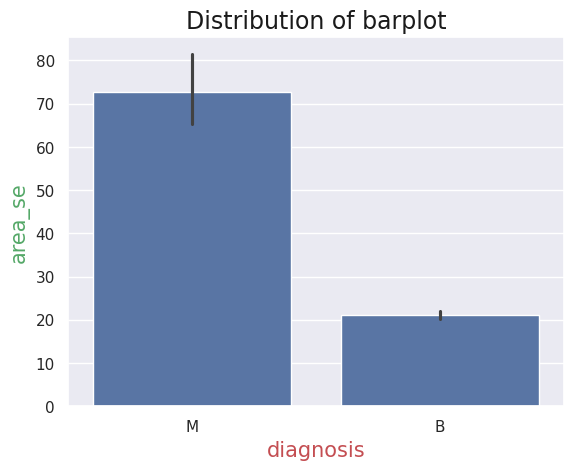

In [33]:
sns.barplot(data=df,x="diagnosis",y="area_se")
plt.title("Distribution of barplot",fontsize=17,c="k")
plt.xlabel("diagnosis",fontsize=15,c="r")
plt.ylabel("area_se",fontsize=15,c="g")
plt.show()




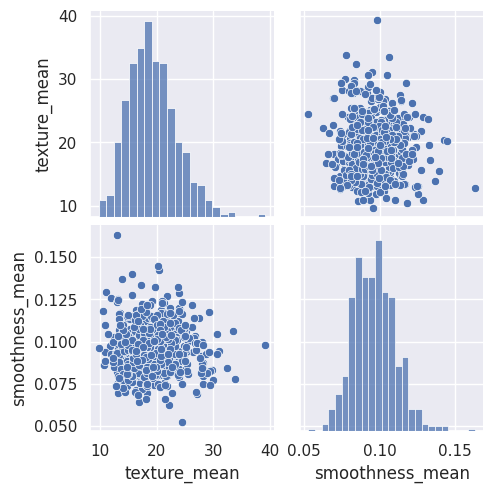

In [34]:
sns.pairplot(df,vars=["texture_mean","smoothness_mean"])
plt.show()

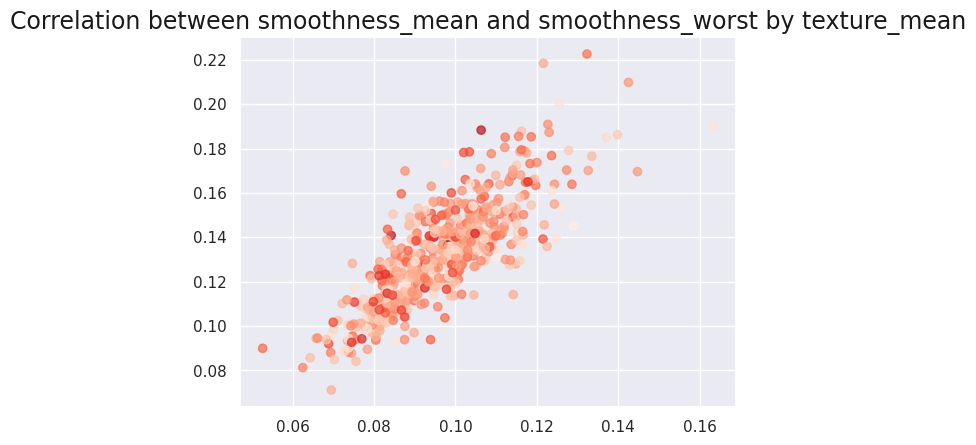

In [35]:
plt.scatter(x=df["smoothness_mean"],y=df["smoothness_worst"]
            ,cmap=plt.get_cmap("Reds"),c=df["texture_mean"],alpha=0.7)
plt.title("Correlation between smoothness_mean and smoothness_worst by texture_mean",fontsize=17,c="k")
plt.show()

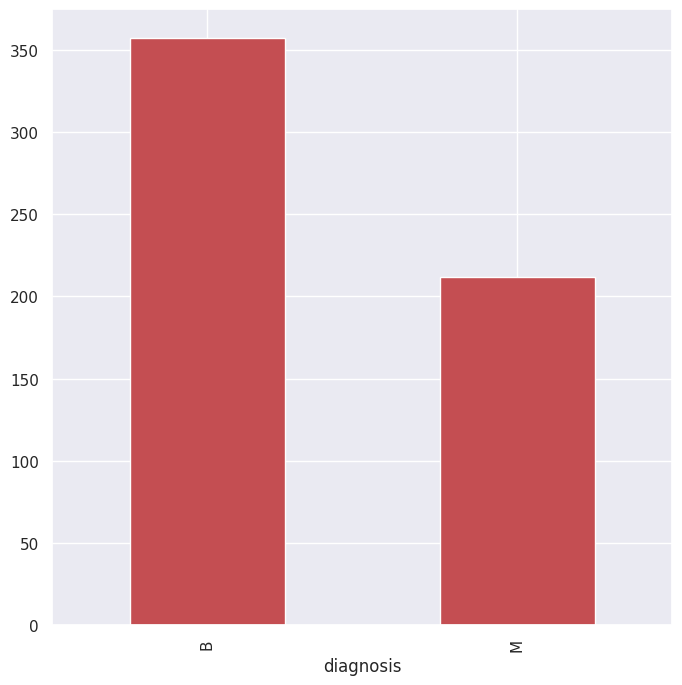

In [36]:
plt.figure(figsize=(8,8))
df.diagnosis.value_counts().plot(kind="bar",color="r")
plt.show()

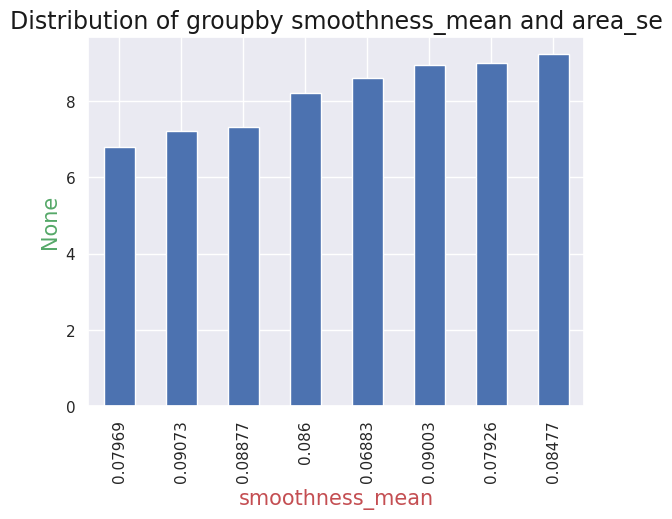

In [37]:
df.groupby("smoothness_mean")["area_se"].mean().sort_values().head(8).plot(kind="bar")
plt.title("Distribution of groupby smoothness_mean and area_se",fontsize=17,c="k")
plt.xlabel("smoothness_mean",fontsize=15,c="r")
plt.ylabel("None",fontsize=15,c="g")
plt.show()


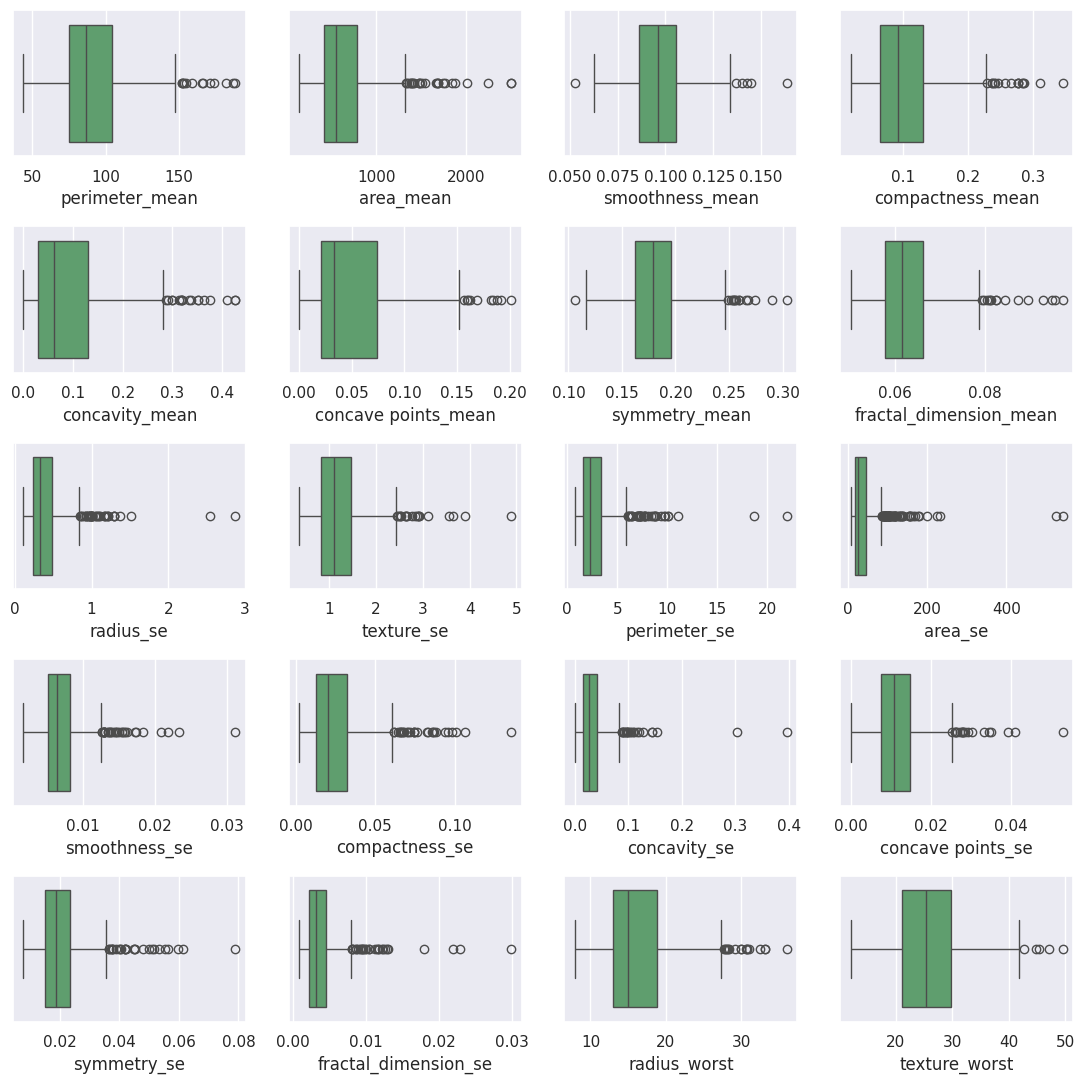

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(11,11))
columns = df.columns[4:24]
for j, i in enumerate(columns, start=1):  ## count columns start with 1
    plt.subplot(5, 4, j)
    sns.boxplot(x=df[i], color="g")
plt.tight_layout() # to avoid overlapping charts
plt.show()

<Axes: >

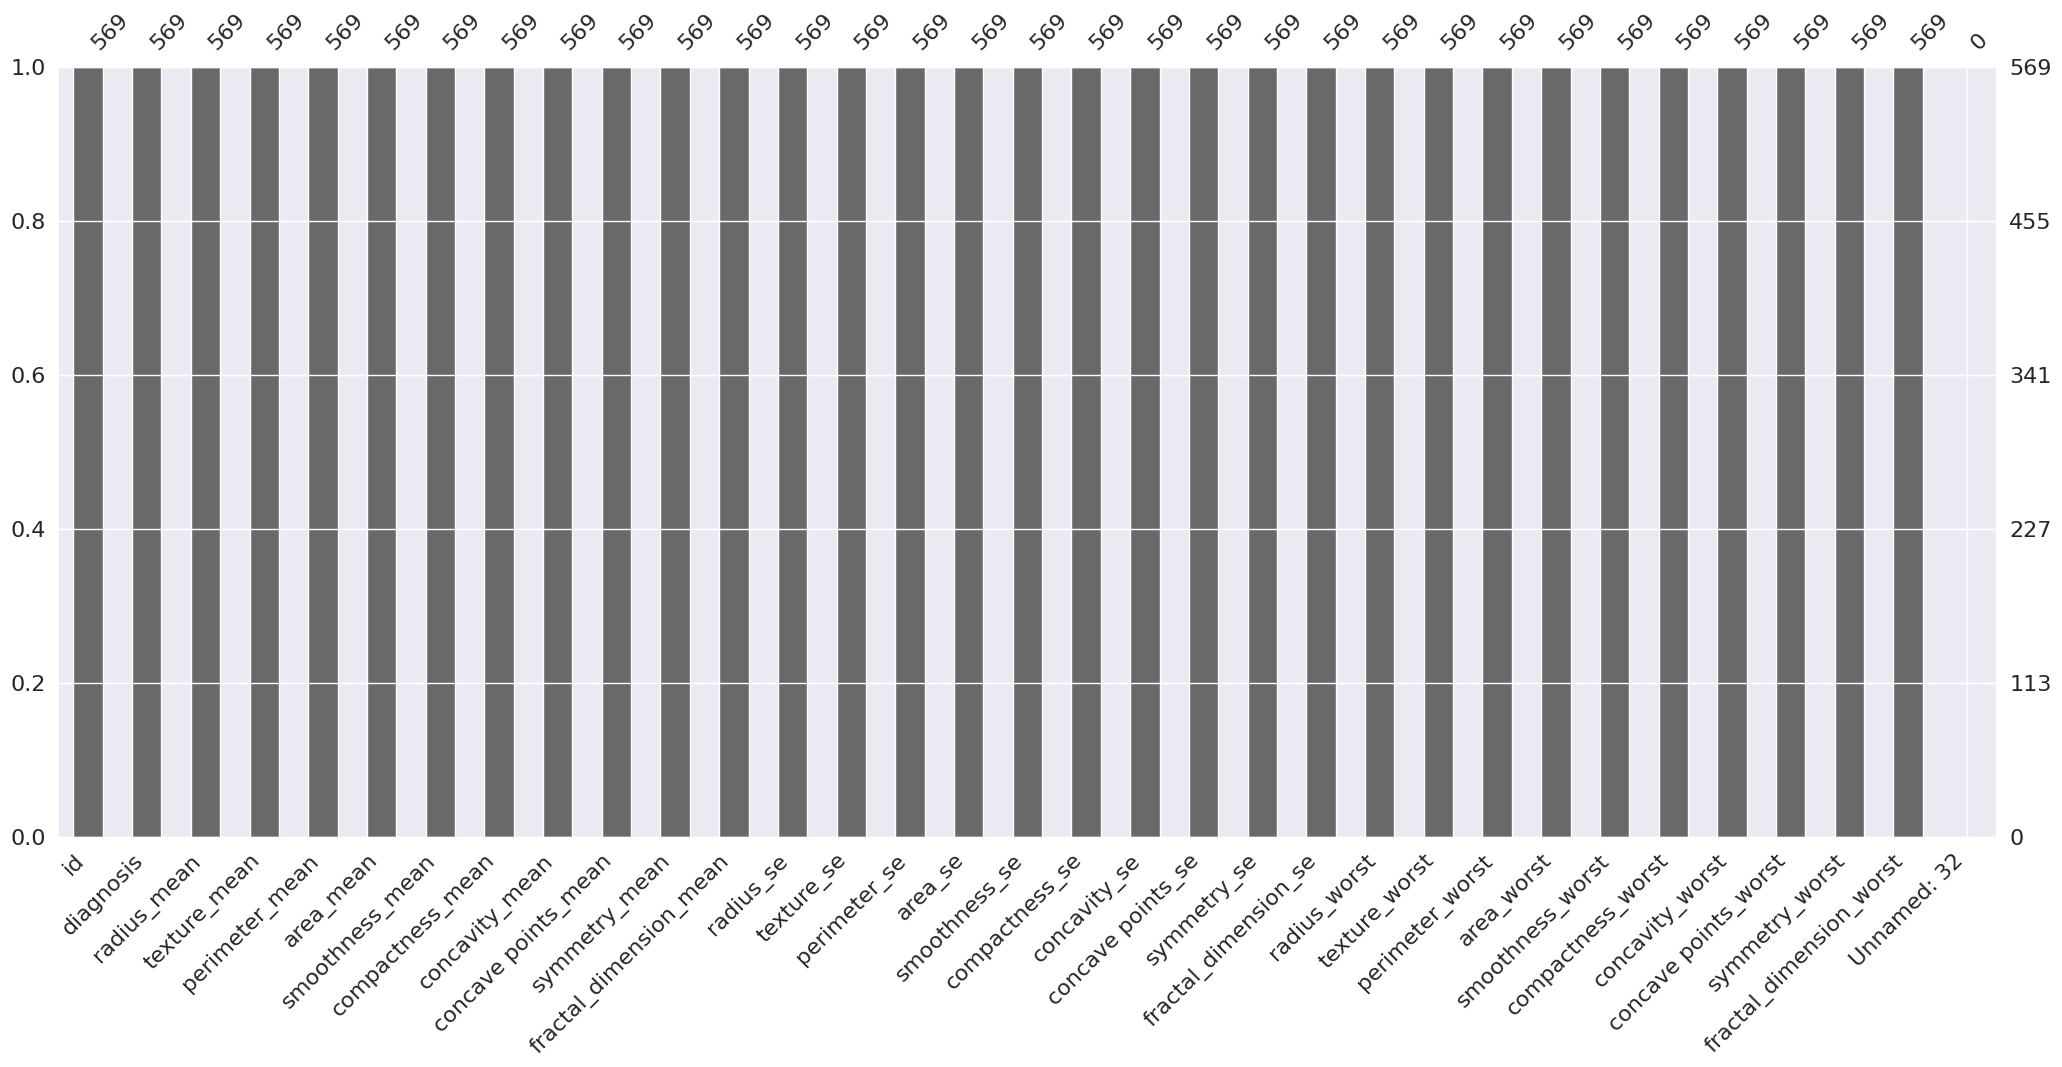

In [39]:
msno.bar(df)

In [40]:
## transform column in dataset to numeric
Encoder=LabelEncoder()
df["diagnosis"]=Encoder.fit_transform(df["diagnosis"])
df["diagnosis"]

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [41]:
df

id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
0      842302          1        17.99         10.38          122.80   
1      842517          1        20.57         17.77          132.90   
2    84300903          1        19.69         21.25          130.00   
3    84348301          1        11.42         20.38           77.58   
4    84358402          1        20.29         14.34          135.10   
..        ...        ...          ...           ...             ...   
564    926424          1        21.56         22.39          142.00   
565    926682          1        20.13         28.25          131.20   
566    926954          1        16.60         28.08          108.30   
567    927241          1        20.60         29.33          140.10   
568     92751          0         7.76         24.54           47.92   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
0       1001.0          0.11840           0.27760         0.30010   
1       1326.0          0.08474           0.07864         0.08690   
2       1203.0          0.10960           0.15990         0.19740   
3        386.1          0.14250           0.28390         0.24140   
4       1297.0          0.10030           0.13280         0.19800   
..         ...              ...               ...             ...   
564     1479.0          0.11100           0.11590         0.24390   
565     1261.0          0.09780           0.10340         0.14400   
566      858.1          0.08455           0.10230         0.09251   
567     1265.0          0.11780           0.27700         0.35140   
568      181.0          0.05263           0.04362         0.00000   

     concave points_mean  ...  texture_worst  perimeter_worst  area_worst  \
0                0.14710  ...          17.33           184.60      2019.0   
1                0.07017  ...          23.41           158.80      1956.0   
2                0.12790  ...          25.53           152.50      1709.0   
3                0.10520  ...          26.50            98.87       567.7   
4                0.10430  ...          16.67           152.20      1575.0   
..                   ...  ...            ...              ...         ...   
564              0.13890  ...          26.40           166.10      2027.0   
565              0.09791  ...          38.25           155.00      1731.0   
566              0.05302  ...          34.12           126.70      1124.0   
567              0.15200  ...          39.42           184.60      1821.0   
568              0.00000  ...          30.37            59.16       268.6   

     smoothness_worst  compactness_worst  concavity_worst  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     concave points_worst  symmetry_worst  fractal_dimension_worst  \
0                  0.2654          0.4601                  0.11890   
1                  0.1860          0.2750                  0.08902   
2                  0.2430          0.3613                  0.08758   
3                  0.2575          0.6638                  0.17300   
4                  0.1625          0.2364                  0.07678   
..                    ...             ...                      ...   
564                0.2216          0.2060                  0.07115   
565                0.1628          0.2572                  0.06637   
566                0.1418          0.2218

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


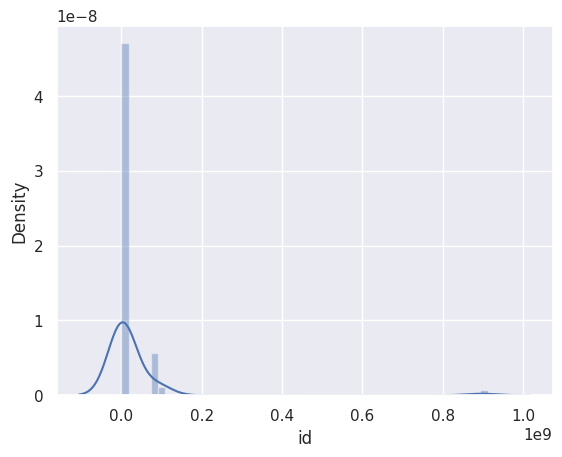

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


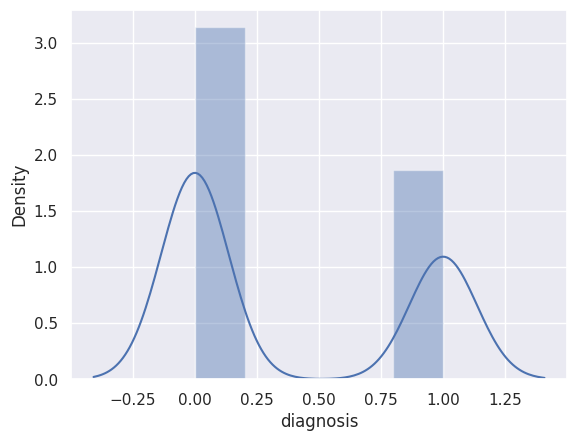

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


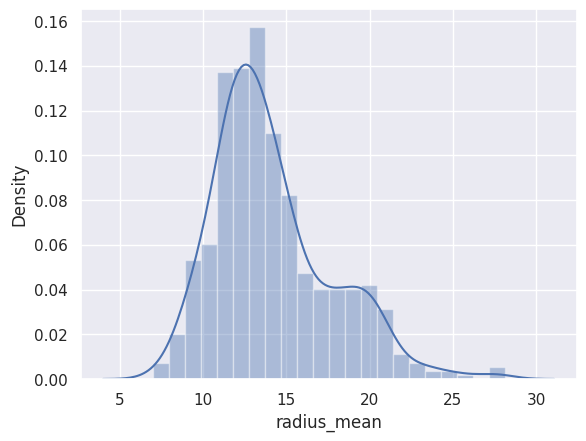

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


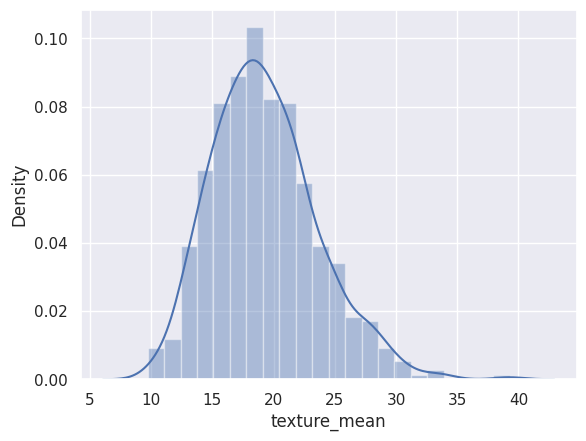

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


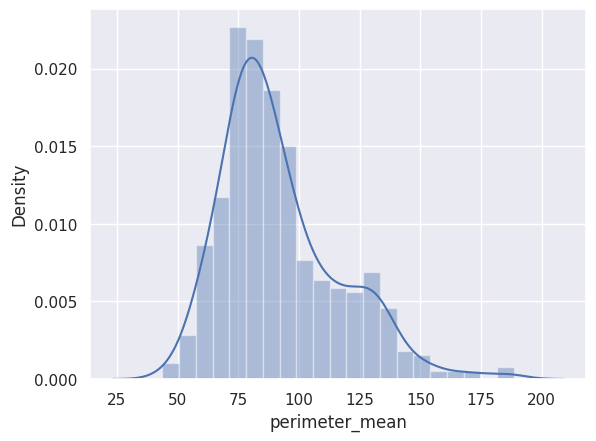

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


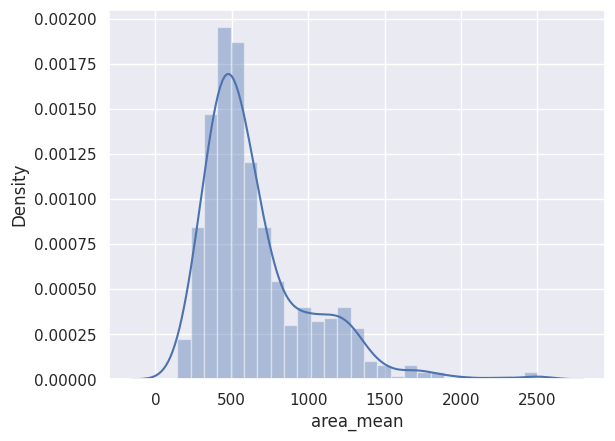

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


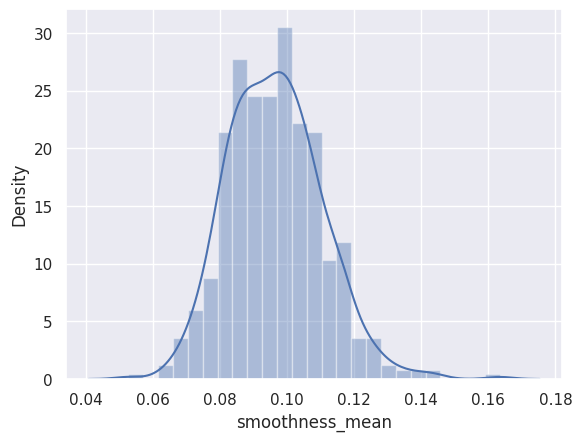

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


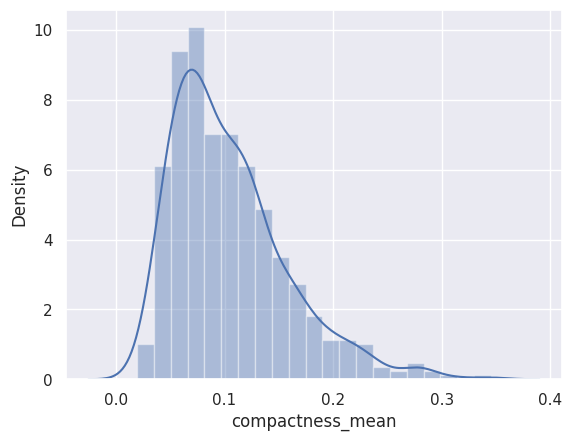

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


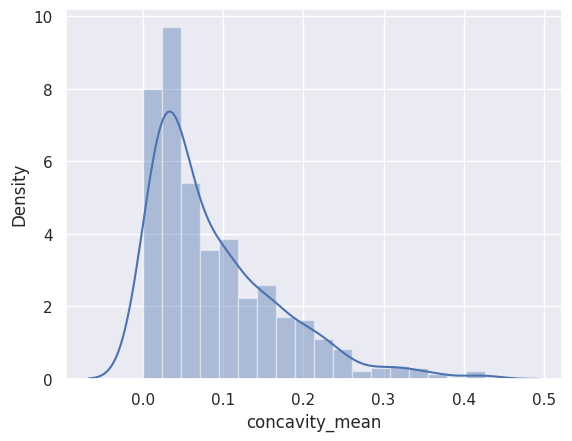

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


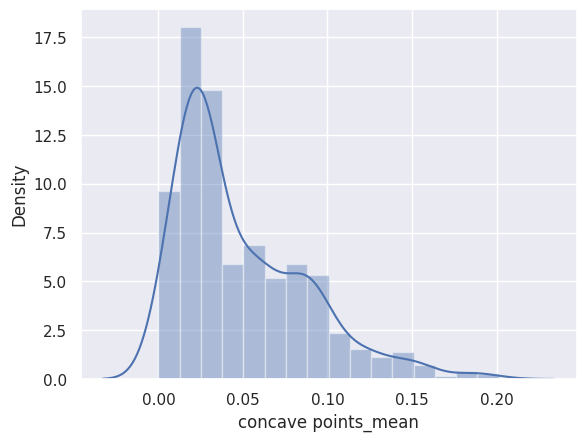

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


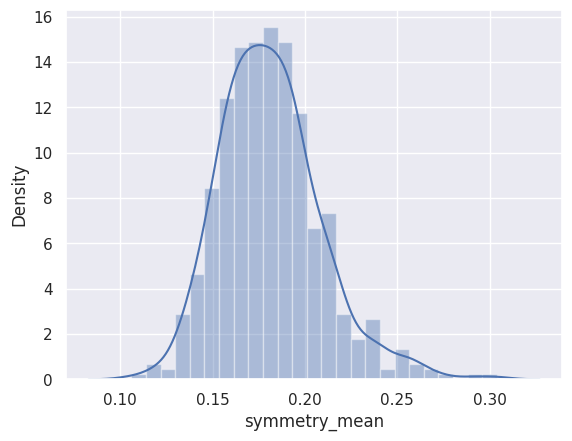

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


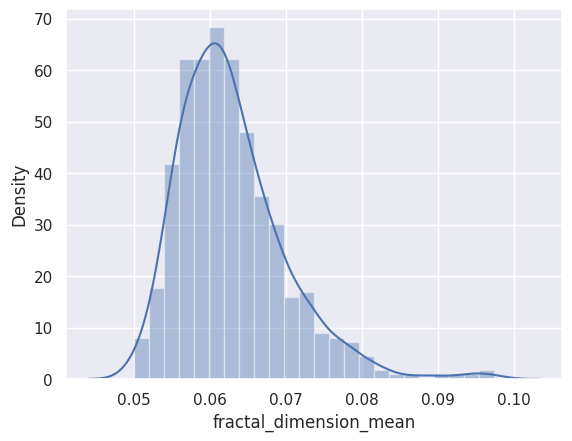

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


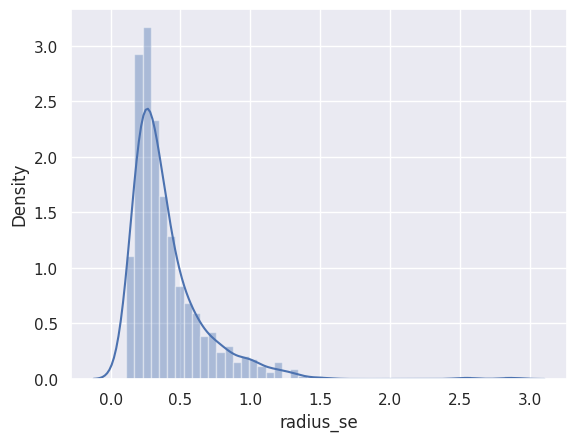

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


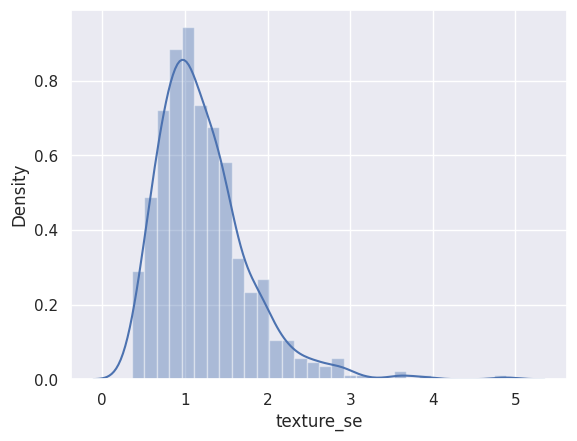

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


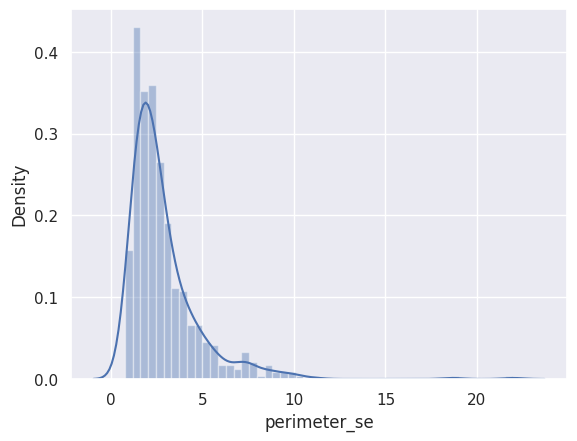

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


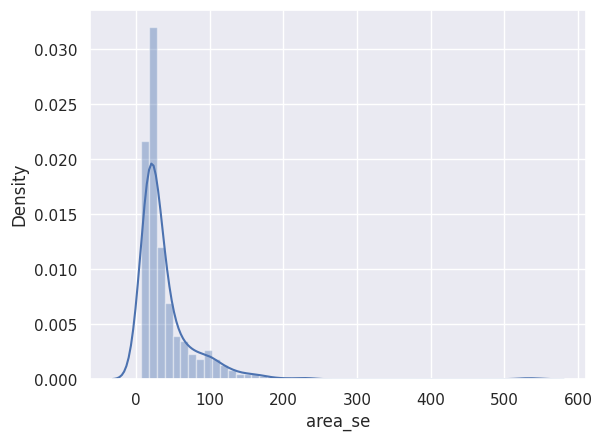

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


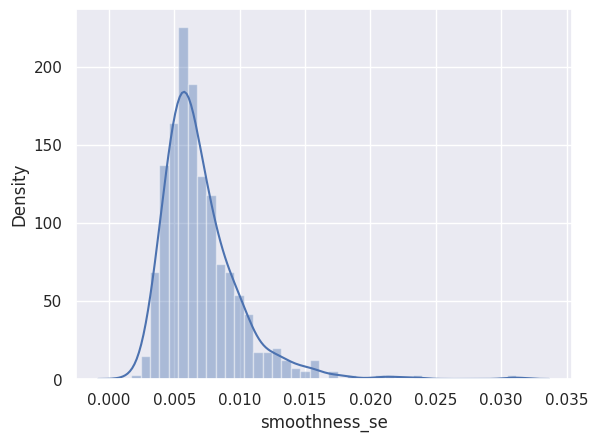

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


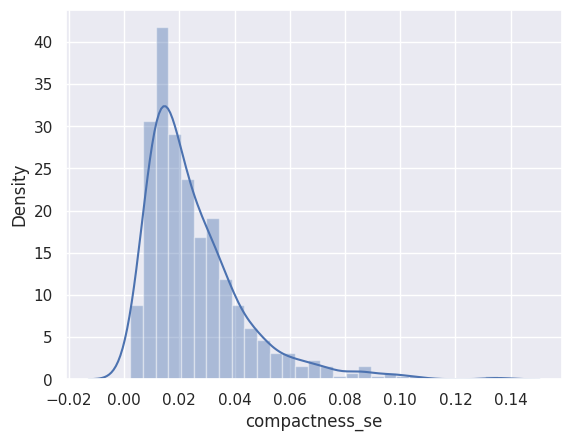

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


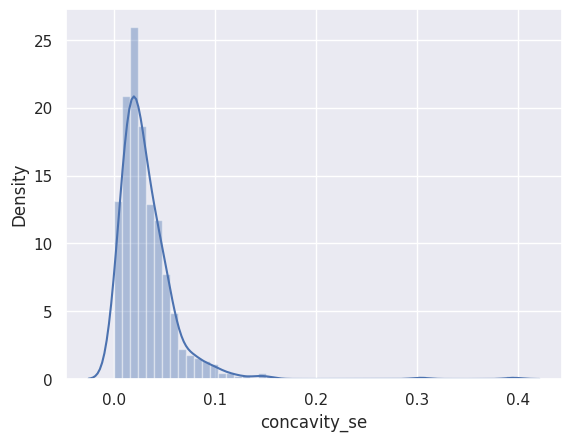

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


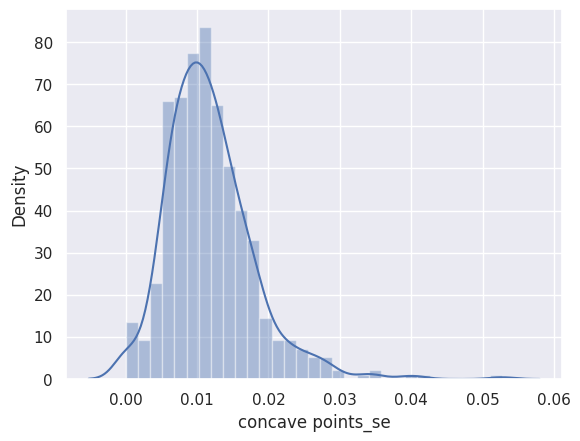

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


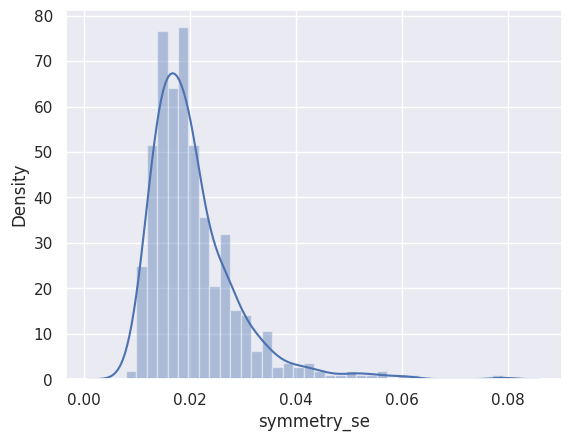

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


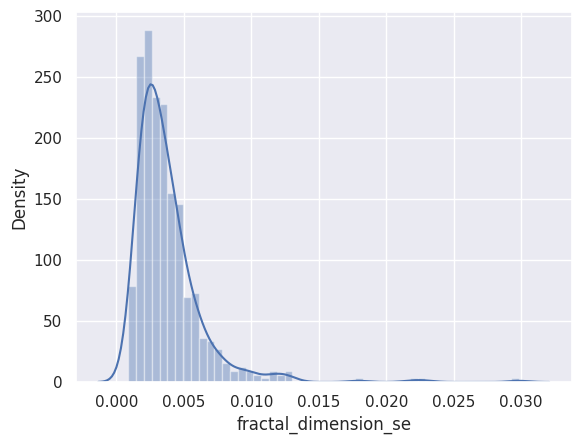

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


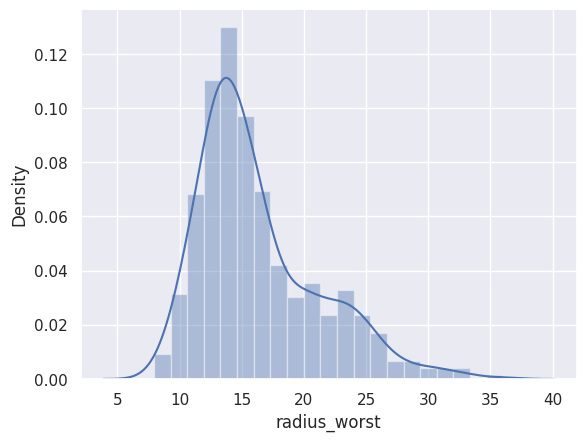

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


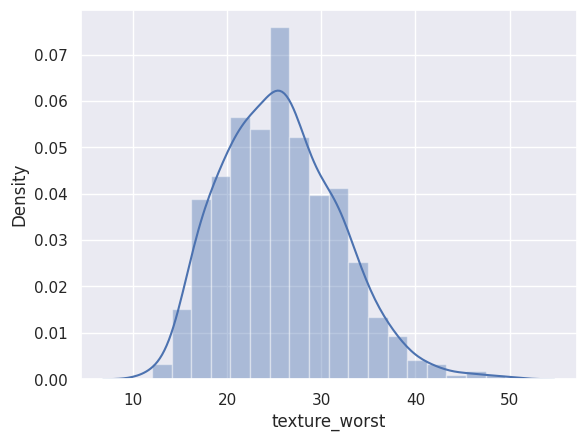

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


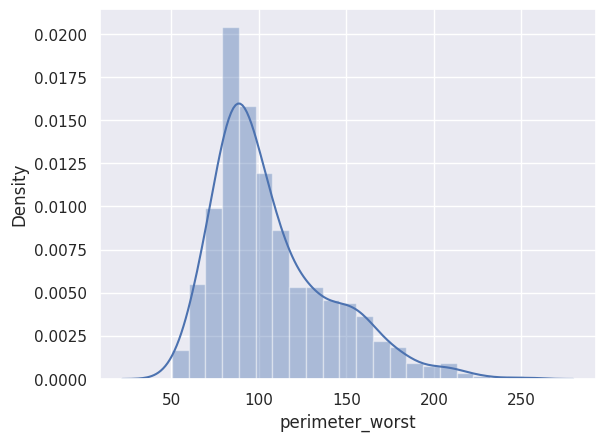

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


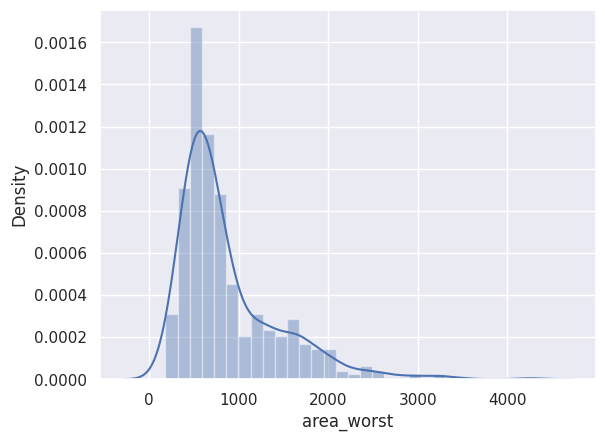

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


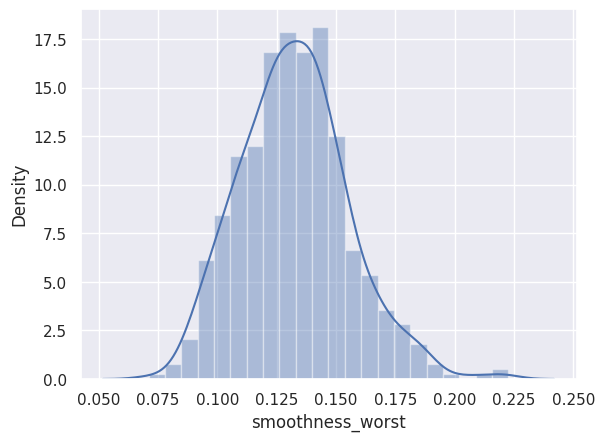

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


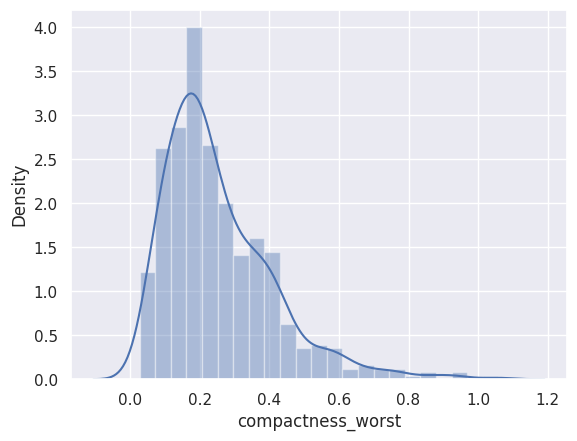

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


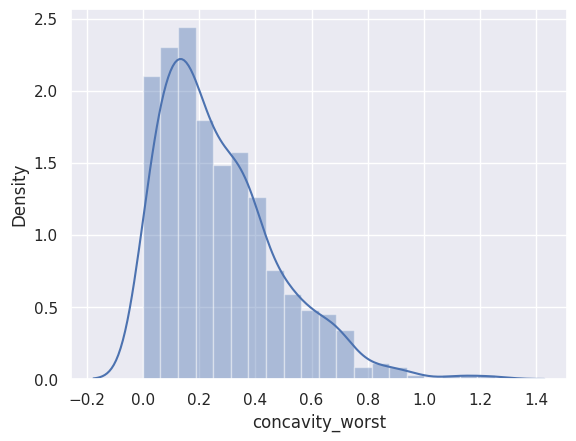

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


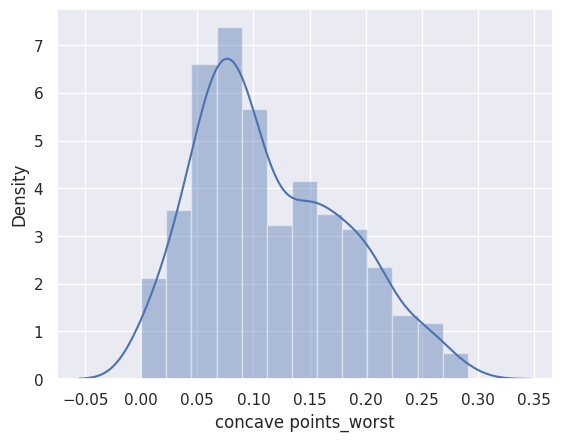

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


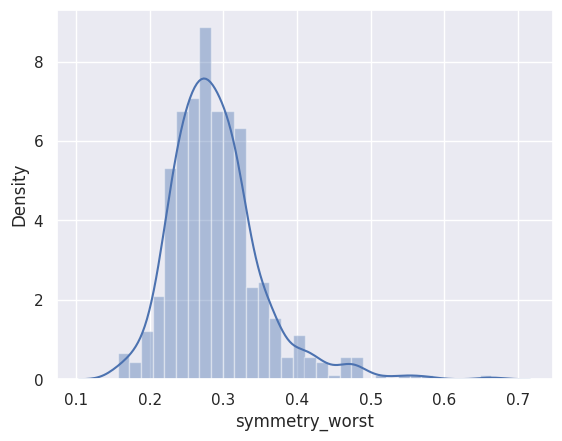

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


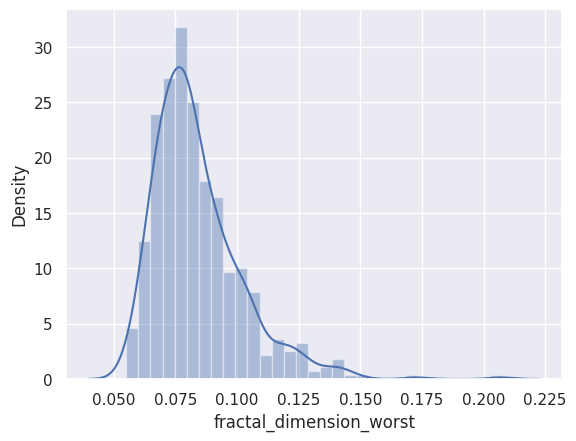

<ipython-input-42-c4c61ec8f0bb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2464: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


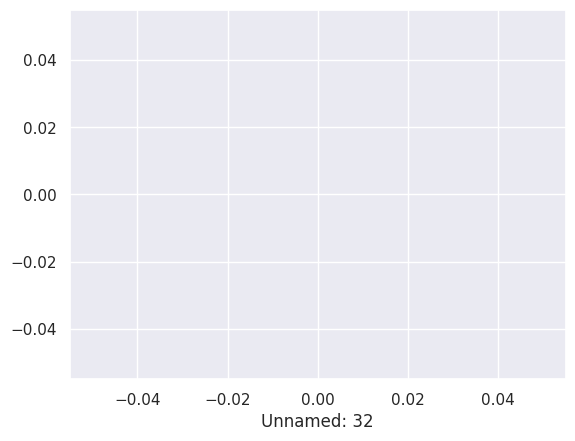

In [42]:
for i in df:
    sns.distplot(df[i])
    plt.show()

In [43]:
fig = px.histogram(df,x="diagnosis",color="diagnosis")
fig.show()

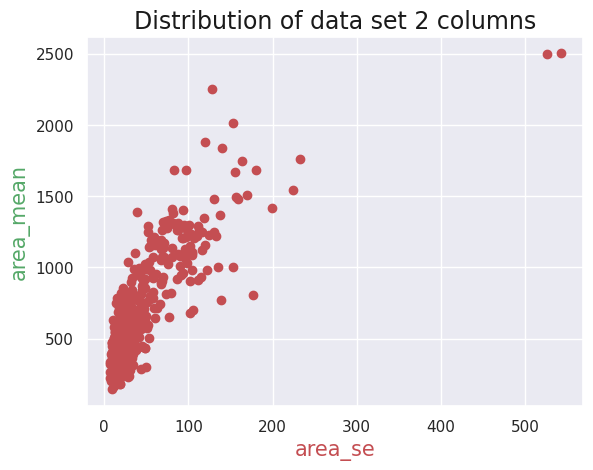

In [44]:
plt.scatter(x=df["area_se"],y=df["area_mean"],c="r")
plt.title("Distribution of data set 2 columns",fontsize=17,c="k")
plt.xlabel("area_se",fontsize=15,c="r")
plt.ylabel("area_mean",fontsize=15,c="g")
plt.show()

<Axes: >

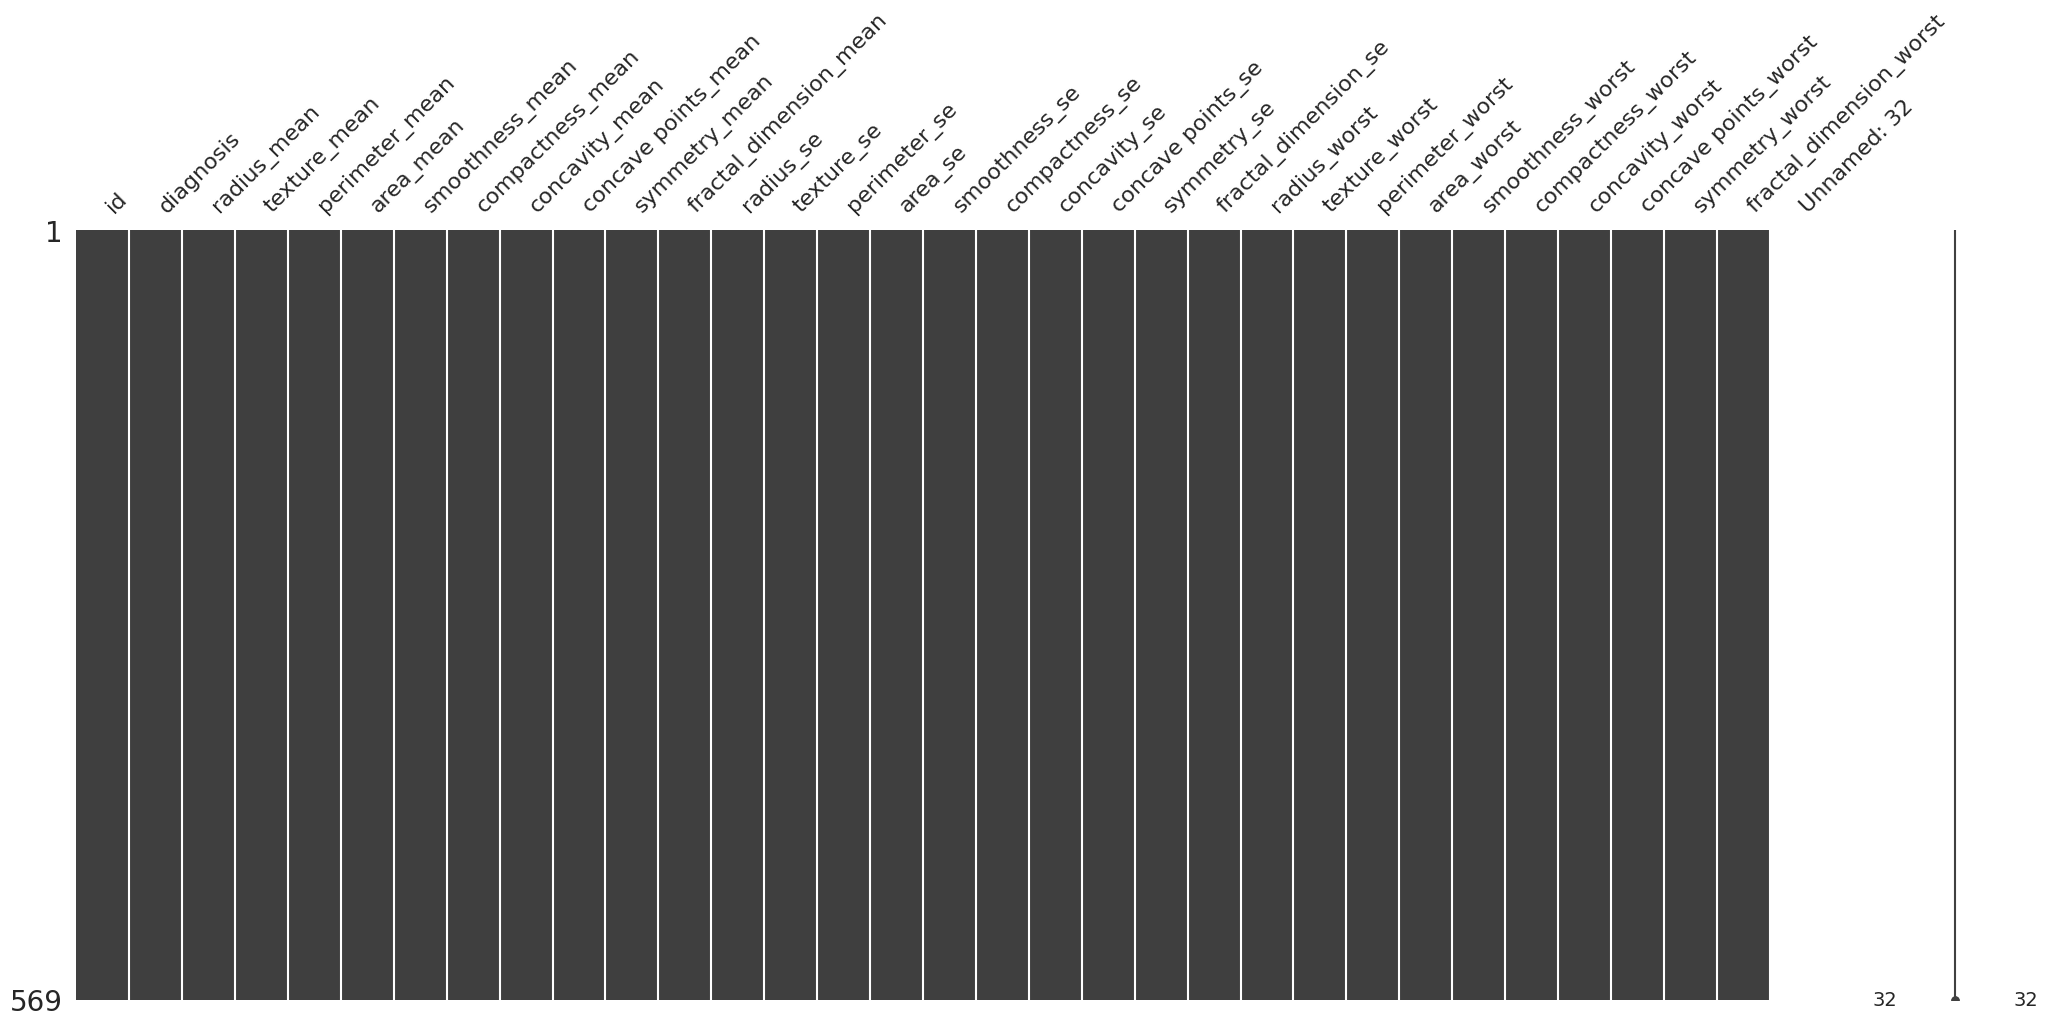

In [45]:
msno.matrix(df)

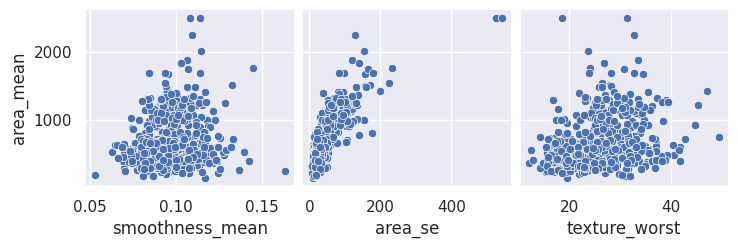

In [46]:
sns.pairplot(data=df,x_vars=["smoothness_mean","area_se","texture_worst"],
             y_vars=["area_mean"])
plt.show()

In [47]:
## feature selection
df=df.drop("Unnamed: 32",axis=1)
df

id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
0      842302          1        17.99         10.38          122.80   
1      842517          1        20.57         17.77          132.90   
2    84300903          1        19.69         21.25          130.00   
3    84348301          1        11.42         20.38           77.58   
4    84358402          1        20.29         14.34          135.10   
..        ...        ...          ...           ...             ...   
564    926424          1        21.56         22.39          142.00   
565    926682          1        20.13         28.25          131.20   
566    926954          1        16.60         28.08          108.30   
567    927241          1        20.60         29.33          140.10   
568     92751          0         7.76         24.54           47.92   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
0       1001.0          0.11840           0.27760         0.30010   
1       1326.0          0.08474           0.07864         0.08690   
2       1203.0          0.10960           0.15990         0.19740   
3        386.1          0.14250           0.28390         0.24140   
4       1297.0          0.10030           0.13280         0.19800   
..         ...              ...               ...             ...   
564     1479.0          0.11100           0.11590         0.24390   
565     1261.0          0.09780           0.10340         0.14400   
566      858.1          0.08455           0.10230         0.09251   
567     1265.0          0.11780           0.27700         0.35140   
568      181.0          0.05263           0.04362         0.00000   

     concave points_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0                0.14710  ...        25.380          17.33           184.60   
1                0.07017  ...        24.990          23.41           158.80   
2                0.12790  ...        23.570          25.53           152.50   
3                0.10520  ...        14.910          26.50            98.87   
4                0.10430  ...        22.540          16.67           152.20   
..                   ...  ...           ...            ...              ...   
564              0.13890  ...        25.450          26.40           166.10   
565              0.09791  ...        23.690          38.25           155.00   
566              0.05302  ...        18.980          34.12           126.70   
567              0.15200  ...        25.740          39.42           184.60   
568              0.00000  ...         9.456          30.37            59.16   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0        2019.0           0.16220            0.66560           0.7119   
1        1956.0           0.12380            0.18660           0.2416   
2        1709.0           0.14440            0.42450           0.4504   
3         567.7           0.20980            0.86630           0.6869   
4        1575.0           0.13740            0.20500           0.4000   
..          ...               ...                ...              ...   
564      2027.0           0.14100            0.21130           0.4107   
565      1731.0           0.11660            0.19220           0.3215   
566      1124.0           0.11390            0.30940           0.3403   
567      1821.0           0.16500            0.86810           0.9387   
568       268.6           0.08996            0.06444           0.0000   

     concave points_worst  symmetry_worst  fractal_dimension_worst  
0                  0.2654          0.4601                  0.11890  
1                  0.1860          0.2750                  0.08902  
2                  0.2430          0.3613                  0.08758  
3                  0.2575          0.6638                  0.17300  
4                  0.1625          0.2364                  0.07678  
..                    ...             ...                      ...  
564                0

In [48]:
## split data to x,y
x=df.drop("diagnosis",axis=1)
y=df["diagnosis"]


In [49]:
x

id  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302        17.99         10.38          122.80     1001.0   
1      842517        20.57         17.77          132.90     1326.0   
2    84300903        19.69         21.25          130.00     1203.0   
3    84348301        11.42         20.38           77.58      386.1   
4    84358402        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564    926424        21.56         22.39          142.00     1479.0   
565    926682        20.13         28.25          131.20     1261.0   
566    926954        16.60         28.08          108.30      858.1   
567    927241        20.60         29.33          140.10     1265.0   
568     92751         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0           0.2419  ...        25.380          17.33           184.60   
1           0.1812  ...        24.990          23.41           158.80   
2           0.2069  ...        23.570          25.53           152.50   
3           0.2597  ...        14.910          26.50            98.87   
4           0.1809  ...        22.540          16.67           152.20   
..             ...  ...           ...            ...              ...   
564         0.1726  ...        25.450          26.40           166.10   
565         0.1752  ...        23.690          38.25           155.00   
566         0.1590  ...        18.980          34.12           126.70   
567         0.2397  ...        25.740          39.42           184.60   
568         0.1587  ...         9.456          30.37            59.16   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0        2019.0           0.16220            0.66560           0.7119   
1        1956.0           0.12380            0.18660           0.2416   
2        1709.0           0.14440            0.42450           0.4504   
3         567.7           0.20980            0.86630           0.6869   
4        1575.0           0.13740            0.20500           0.4000   
..          ...               ...                ...              ...   
564      2027.0           0.14100            0.21130           0.4107   
565      1731.0           0.11660            0.19220           0.3215   
566      1124.0           0.11390            0.30940           0.3403   
567      1821.0           0.16500            0.86810           0.9387   
568       268.6           0.08996            0.06444           0.0000   

     concave points_worst  symmetry_worst  fractal_dimension_worst  
0                  0.2654          0.4601                  0.11890  
1                  0.1860          0.2750                  0.08902  
2                  0.2430          0.3613                  0.08758  
3                  0.2575          0.6638                  0.17300  
4                  0.1625          0.2364                  0.07678  
..                    ...             ...

In [50]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [51]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15,shuffle=True,random_state=42)
print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)


x_train shape (483, 31)
x_test shape (86, 31)
y_train shape (483,)
y_test shape (86,)


Models

RandomForestClassifier

In [52]:
rf=RandomForestClassifier(n_estimators=6,max_depth=4,n_jobs=None)
rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=4, n_estimators=6)

In [53]:
rf.score(x_train,y_train)

0.9772256728778468

In [54]:
y_pred_rf=rf.predict(x_test)
y_pred_rf

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [55]:
accuracy_rf=accuracy_score(y_test,y_pred_rf)
precision_rf=precision_score(y_test,y_pred_rf)
recall_rf=recall_score(y_test,y_pred_rf)

print(f"accuracy_rf: {accuracy_rf}")
print(f"precision_rf: {precision_rf}")
print(f"recall_rf: {recall_rf}")

cm=confusion_matrix(y_test,y_pred_rf)

accuracy_rf: 0.9534883720930233
precision_rf: 0.9666666666666667
recall_rf: 0.90625


In [56]:
cm

array([[53,  1],
       [ 3, 29]])

<Axes: >

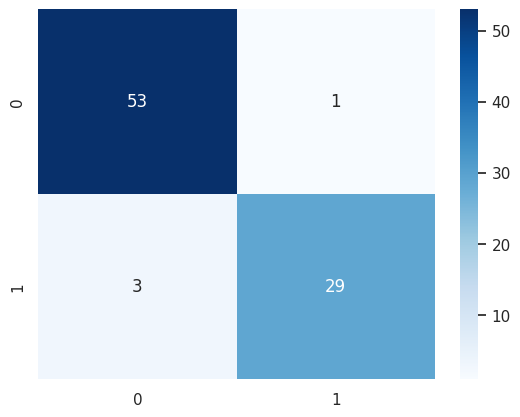

In [57]:
sns.heatmap(cm,annot=True,cmap="Blues")

In [58]:
## Tuning withe GrideSearchCv
parms_test={"n_estimators":[10,20,30,40]
            ,"max_depth":[2,4,6,8]}
grid_search=GridSearchCV(estimator=rf,param_grid=parms_test
                          ,cv=7,n_jobs=-1,return_train_score=True)

In [59]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



GridSearchCV(cv=7,
             estimator=RandomForestClassifier(max_depth=4, n_estimators=6),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8],
                         'n_estimators': [10, 20, 30, 40]},
             return_train_score=True)

In [60]:
## get best model hyperparameters
best_model=grid_search.best_estimator_
best_model

RandomForestClassifier(max_depth=8, n_estimators=30)

In [61]:
## get best score
score_best=grid_search.best_score_
print("score after tuning",score_best)

score after tuning 0.9648033126293996


In [62]:
## tuning with RandomizedSearchCV
parms_test={"n_estimators":[10,14,40,50]
            ,"max_depth":[5,8,9,13]}

random_search=RandomizedSearchCV(estimator=rf,param_distributions=parms_test
                                 ,n_iter=7,cv=5,random_state=422,verbose=5)

In [63]:
random_search.fit(x_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ......max_depth=5, n_estimators=10;, score=0.959 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=10;, score=0.959 total time=   0.0s
[CV 3/5] END ......max_depth=5, n_estimators=10;, score=0.948 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=10;, score=0.958 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=10;, score=0.938 total time=   0.0s
[CV 1/5] END ......max_depth=9, n_estimators=14;, score=0.969 total time=   0.0s
[CV 2/5] END ......max_depth=9, n_estimators=14;, score=0.959 total time=   0.0s
[CV 3/5] END ......max_depth=9, n_estimators=14;, score=0.948 total time=   0.0s
[CV 4/5] END ......max_depth=9, n_estimators=14;, score=0.958 total time=   0.0s
[CV 5/5] END ......max_depth=9, n_estimators=14;, score=0.938 total time=   0.0s
[CV 1/5] END ......max_depth=9, n_estimators=50;, score=0.969 total time=   0.1s
[CV 2/5] END ......max_depth=9, n_estimators=50;,

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=4,
                                                    n_estimators=6),
                   n_iter=7,
                   param_distributions={'max_depth': [5, 8, 9, 13],
                                        'n_estimators': [10, 14, 40, 50]},
                   random_state=422, verbose=5)

In [64]:
## get best score
score_best=random_search.best_score_
print("score after tuning",score_best)

score after tuning 0.9647551546391753


DecisionTreeClassifier

In [65]:
dt=DecisionTreeClassifier(max_depth=5,random_state=42)
dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [66]:
dt.score(x_train,y_train)

0.9958592132505176

In [67]:
y_pred_dt=dt.predict(x_test)
y_pred_dt

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1])

In [68]:
accuracy_dt=accuracy_score(y_test,y_pred_dt)
precision_dt=precision_score(y_test,y_pred_dt)
recall_dt=recall_score(y_test,y_pred_dt)

print(f"accuracy_dt: {accuracy_dt}")
print(f"precision_dt: {precision_dt}")
print(f"recall_dt: {recall_dt}")

cm=confusion_matrix(y_test,y_pred_dt)

accuracy_dt: 0.9302325581395349
precision_dt: 0.9333333333333333
recall_dt: 0.875


In [69]:
cm

array([[52,  2],
       [ 4, 28]])

<Axes: >

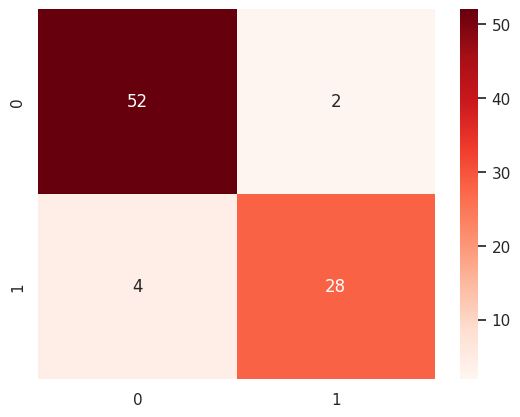

In [70]:
sns.heatmap(cm,annot=True,cmap="Reds")

SVM

In [ ]:
sm=SVC(kernel="rbf",C=0.9)
sm.fit(x_train,y_train)

In [ ]:
sm.score(x_train,y_train)

In [ ]:
y_pred_sm=sm.predict(x_test)
y_pred_sm

In [ ]:
accuracy_sm=accuracy_score(y_test,y_pred_sm)
precision_sm=precision_score(y_test,y_pred_sm)
recall_sm=recall_score(y_test,y_pred_sm)

print(f"accuracy_sm:{accuracy_sm}")
print(f"precision_sm:{precision_sm}")
print(f"recall_sm:{recall_sm}")

LogisticRegression

In [ ]:
lg=LogisticRegression()
lg.fit(x_train,y_train)

In [ ]:
lg.score(x_train,y_train)

In [ ]:
y_pred_lg=lg.predict(x_test)
y_pred_lg

In [ ]:
accuracy_lg=accuracy_score(y_test,y_pred_lg)
cm=confusion_matrix(y_test,y_pred_lg)

print(f"accuracy_lg:{accuracy_lg}")


In [ ]:
cm

In [ ]:
sns.heatmap(cm,annot=True,cmap="Greens")

XGboost

In [ ]:
xg=xgb.XGBClassifier(n_estimators=4)
xg.fit(x_train,y_train)

In [ ]:
xg.score(x_train,y_train)

In [ ]:
y_pred_xg=xg.predict(x_test)
y_pred_xg

In [ ]:
accuracy_xg=accuracy_score(y_test,y_pred_xg)
precision_xg=precision_score(y_test,y_pred_xg)
recall_xg=recall_score(y_test,y_pred_xg)

print(f"accuracy_xg:{accuracy_xg}")
print(f"precision_xg:{precision_xg}")
print(f"recall_xg:{recall_xg}")

In [ ]:
cm=confusion_matrix(y_test,y_pred_xg)
cm

In [ ]:
sns.heatmap(cm,annot=True)

ANN

In [ ]:
model=Sequential()
model.add(Dense(100,activation="relu",input_shape=(x_train.shape[1],)))
model.add(Dense(150,activation="relu"))
model.add(Dense(160,activation="relu"))
model.add(Dense(1))

summary=model.summary()

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

model.fit(x_train,y_train,epochs=50)

loss , accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)





